# Statistical Analysis of Epoxy Resin Products in Etsy

    A friend of mine wants to make epoxy resin products and sell them online. 
    But she is not sure which product type and product features will bring her most profit.
    
    So I decided to make a statistical analysis.
    Main questions, we are trying to answer in this analysis:
        1. Which epoxy resin product should we sell?
        2. Which feautures should this product have?

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import nltk
import requests
from bs4 import BeautifulSoup
from functools import reduce 
import re
import collections
from scipy import stats
import sweetviz

## Data Collection  

    I decided to get data from Etsy, which is a renowned online marketplace to sell handcrafted products
    and going to scrape data myself using Beautiful Soup.
    
    To get information about product types and features I'm going to get name, description, details of
    products.
    
    To get information about profits(=revenue-costs)) of products, we need sales, price and the cost of 
    products. Here we have some challanges:
    
         1. Unfortunately Etsy doesn't provide any data about the cost of the products. So I talked to my 
            friend and she said the cost of epoxy resin products are small and more or less equal. According to 
            this statement we can actually ignore cost aspect and do our analysis based on 
            revenues(=sales*price).
    
         2. But we have another problem. In Etsy we can't get sales of products, but sales of sellers. 
            So I thought how I could do this analysis with the resources at hand. I am going to get estimated 
            revenues of sellers using sales and mean of the prices and investigate selling which product types 
            and having which product feautures are related success of sellers
           
     This way I decided which data I am going to collect. 
     
     The steps I used to scrape this data:
         1. I searched product types based on my research in Etsy. And entered search key, search url and max. 
            number of relevant pages in a dictionary. (search key: [search url, max. pages])
         2. I got the links of products from the search pages.
         3. I got the links of seller from the product pages.
         4. I got the unique seller links from seller links.
         5. I got the id, sales, avg. price and product links data from the seller pages.
         6. I got the name, description, details, price, seller id data from the product pages (collected in 
            the last step)
         7. I saved the collected data to csv files for later use.
         *Quick Tip: If you are scraping data from too many pages, it can take really long time. If you suspect
          your internet connection is not steady, you can divide the pages in groups and save the data 
          collected after scraping each group. So that you don't lose all the data you collected due to 
          a little connection error.

In [ ]:
searches = {'epoxy resin necklace' : ['https://www.etsy.com/search?q=epoxy+resin+necklace&order=most_relevant&ref=pagination&explicit_scope=1&locationQuery=2921044&entry_point=local_search%2F5&page=',
                                     19],
            
            'epoxy resin earring': ['https://www.etsy.com/search?q=epoxy+resin+earrings&order=most_relevant&ref=pagination&explicit_scope=1&locationQuery=2921044&entry_point=local_search&page=',
                                   9],
            'epoxy resin ring': ['https://www.etsy.com/search?q=epoxy+resin+ring&order=most_relevant&locationQuery=2921044&spell_correction_via_mmx=1&ref=pagination&page=', 
                 1],
            'epoxy resin keychain': ['https://www.etsy.com/search?q=epoxy+resin+keychain&explicit=1&locationQuery=2921044&ref=pagination&page=', 
                                     13]
}

In [ ]:
def requireNonNone(obj):
    if obj == None:
        return BeautifulSoup('NoneType')
    else:
        return obj

In [ ]:
def get_search_links(search, search_url, max_pages):
    product_links = []
    for page_no in range(1,max_pages+1):
        page = requests.get(search_url+str(page_no))
        bs = BeautifulSoup(page.content, 'html.parser')
        soup = bs.select(f"a[data-query='{search}']")
        
        for s in soup:
            product_links.append(s['href'])
            
    return product_links

In [ ]:
def get_seller_links(search_links):
    seller_links = []
    
    for link in search_links:
        page = requests.get(link)
        bs = BeautifulSoup(page.content, 'html.parser')
        soup = requireNonNone(bs.select_one('p a.wt-text-link-no-underline'))
        seller_links.append(soup['href'])

    return seller_links

In [ ]:
def get_seller_infos(seller_links):
    id = []
    sales = []
    avg_price = []
    product_links = []
    
    for link in seller_links:
        page = requests.get(link)
        bs = BeautifulSoup(page.content, 'html.parser')
        
        id_ = bs.select_one('h1.mb-lg-1').getText()
        sales_ = bs.select('.pt-xs-3')[0].getText().split()[0]
        
        soup = bs.select('.currency-value')
        prices = list(map(lambda x: float(x.getText().replace(',','')), soup))
        avg_price_ = reduce(lambda x,y: x + y, prices)/len(prices)
        
        product_links_ = []
        soup = bs.select('a[data-listing-id]')
        for s in soup:
            product_links_.append(s['href'])
            
        id.append(id_)
        sales.append(sales_)
        avg_price.append(avg_price_)
        product_links.append(product_links_)
        
            
    return pd.DataFrame(data={'id': id,
                              'sales': sales,
                              'avg_price': avg_price,
                              'product_links': product_links})

In [ ]:
def get_product_infos(product_links):
    name = []
    description = []
    details = []
    price = []
    seller = []
    
    for link in product_links:
        page = requests.get(link)
        bs = BeautifulSoup(page.content, 'html.parser')
        
        name.append(requireNonNone(bs.select_one('[data-component="listing-page-title-component"] h1')).getText())
        description.append(requireNonNone(bs.select_one('[data-id="description-text"] p')).getText())
        price.append(requireNonNone(bs.select_one('p[class="wt-text-title-03 wt-mr-xs-2"]')).getText().replace('€', ''))
        seller.append(requireNonNone(bs.select_one('div[id="listing-page-cart"] a[class="wt-text-link-no-underline"] span')).getText())
        details_selection = bs.select('[id="product-details-content-toggle"] li')
        details_ = []
        for detail in details_selection:
            details_.append(detail.getText())
        details.append(details_)
        
    return pd.DataFrame(data={'name': name,
                              'description': description,
                              'details': details,
                              'price': price,
                              'seller_id': seller})

In [ ]:
search_links = []

for s in searches.keys():
    search_links = search_links + get_search_links(s, searches.get(s)[0], searches.get(s)[1])
    
print('length: ' + str(len(search_links)))
print('search links: ' + str(search_links))

In [ ]:
seller_links = get_seller_links(search_links)

print('length: ' + str(len(seller_links)))
print('search links: ' + str(seller_links))

In [ ]:
seller_links = list(set(seller_links))

print('length: ' + str(len(seller_links)))
print('search links: ' + str(seller_links))

In [ ]:
seller_infos = get_seller_infos(seller_links)

seller_infos

In [ ]:
seller_infos.to_csv('data/seller_infos_scraped.csv')

In [ ]:
product_links = [link for link_array in seller_infos['product_links'] for link in link_array]
len(product_links)

In [ ]:
product_links_separated = []
n_links_to_separate = 1000
for i in range(36):
    product_links_separated.append(product_links[i*n_links_to_separate:(i+1)*n_links_to_separate])
product_links_separated

In [ ]:
product_infos_separated = []
for i in range(36):
    product_infos_separated.append(get_product_infos(product_links_separated[i]))
    product_infos_separated[i].to_csv(f'data/product_infos_separated/product_infos_separated_{i}.csv')

In [ ]:
product_infos_separated = []
for i in range(36):
    product_infos_separated.append(pd.read_csv(f'data/product_infos_separated/product_infos_separated_{i}.csv'))
product_infos = pd.concat(product_infos_separated)
product_infos

In [ ]:
product_infos = product_infos.drop(labels='Unnamed: 0', axis=1)
product_infos.index = range(35004)
product_infos.to_csv('data/product_infos.csv')
product_infos

## Data Cleaning & Preparation 

    Here I clean the data by 
        - handling missing values and duplicates, 
        - cleaning unnecessary and control characters from string columns
    
    I also prepare the data for the analysis by 
        - adding some necessary columns as revenue for seller data and full text for product data
        - changing the data type of columns as needed
        - dropping the unnecessary columns

#### Seller Data

In [ ]:
seller_data = pd.read_csv('data/seller_infos.csv')
seller_data = seller_data.drop(labels='Unnamed: 0', axis=1)
seller_data

,id,sales,avg_price,product_links
0,LifeOfLazyCats,166,8.622000,['https://www.etsy.com/listing/896321786/bow-f...
1,Resinw0rldshop,0,8.236923,['https://www.etsy.com/listing/867818006/table...
2,DziwnaLogika,2,54.232813,['https://www.etsy.com/listing/843506124/storm...
3,yunasoracrafts,199,14.649437,['https://www.etsy.com/listing/896930566/xl-la...
4,ZeitlosSchmuckDesign,1081,46.837000,['https://www.etsy.com/listing/882356908/auror...
...,...,...,...,...
1083,MrsEigenart,22,33.044000,['https://www.etsy.com/listing/662631266/rainb...
1084,HarzGeschenke,1,4.692857,['https://www.etsy.com/listing/876679938/coast...
1085,ZeitlosSchmuckDesign,1081,46.837000,['https://www.etsy.com/listing/882356908/auror...
1086,LaDisDesign,19,27.162750,['https://www.etsy.com/listing/840098790/penda...


In [ ]:
seller_data.dtypes

id                object
sales              int64
avg_price        float64
product_links     object
dtype: object

In [ ]:
print('Number of "NoneType" Values:')
for column in seller_data.columns:
    print(column + ': ' + str(len(np.where(seller_data[column] == 'NoneType')[0])))

print()

print('Number of "None Values:')
print(seller_data.isnull().sum(axis = 0))

Number of "NoneType" Values:
id: 0
sales: 0
avg_price: 0
product_links: 0

Number of "None Values:
id               0
sales            0
avg_price        0
product_links    0
dtype: int64


In [ ]:
seller_data_unique = pd.DataFrame()
for unique_id in seller_data.id.unique():
    index = np.where(seller_data['id']==unique_id)[0][0]
    seller_data_unique = pd.concat([seller_data_unique, seller_data.loc[index]], axis=1)
seller_data_unique = seller_data_unique.T
seller_data_unique.index = range(seller_data_unique.shape[0])
seller_data = seller_data_unique
seller_data

,id,sales,avg_price,product_links
0,LifeOfLazyCats,166,8.622,['https://www.etsy.com/listing/896321786/bow-f...
1,Resinw0rldshop,0,8.23692,['https://www.etsy.com/listing/867818006/table...
2,DziwnaLogika,2,54.2328,['https://www.etsy.com/listing/843506124/storm...
3,yunasoracrafts,199,14.6494,['https://www.etsy.com/listing/896930566/xl-la...
4,ZeitlosSchmuckDesign,1081,46.837,['https://www.etsy.com/listing/882356908/auror...
...,...,...,...,...
238,Beldacci,177,26.2368,['https://www.etsy.com/listing/628103934/belda...
239,DerOekofroschLaden,15,4.71,['https://www.etsy.com/listing/858633082/handm...
240,ALEXASCHA,1296,26.5481,['https://www.etsy.com/listing/784275675/green...
241,PIOFIORE,2,50.5213,['https://www.etsy.com/listing/627735778/earri...


In [ ]:
seller_data = seller_data.drop(labels='product_links', axis=1)
seller_data['revenue'] = seller_data['sales'] * seller_data['avg_price']
seller_data

,id,sales,avg_price,revenue
0,LifeOfLazyCats,166,8.622,1431.25
1,Resinw0rldshop,0,8.23692,0
2,DziwnaLogika,2,54.2328,108.466
3,yunasoracrafts,199,14.6494,2915.24
4,ZeitlosSchmuckDesign,1081,46.837,50630.8
...,...,...,...,...
238,Beldacci,177,26.2368,4643.9
239,DerOekofroschLaden,15,4.71,70.65
240,ALEXASCHA,1296,26.5481,34406.4
241,PIOFIORE,2,50.5213,101.043


In [ ]:
seller_data.to_csv('data/seller_data_preped.csv')

### Product Data

In [ ]:
product_data = pd.read_csv('data/product_infos.csv')
product_data= product_data.drop(labels='Unnamed: 0', axis=1)
product_data

,name,description,details,price,seller_id
0,"\n bow for cats and dogs, pet, patt...",Description,[],\n $7.37+\n ...,\n LifeOfLazyCats\n
1,"\n Scrunchy for you, Christmas, gir...",Description,[],\n $8.05\n ...,\n LifeOfLazyCats\n
2,\n Bandana for cat and dog for Chri...,\n Finally the time has com...,"['\n\nHandmade\n', '\n\n\n\nMaterials: Baumwol...",\n $10.10+\n ...,\n LifeOfLazyCats\n
3,"\n Scrunchy for you, Christmas, gir...",Description,[],\n $8.05\n ...,\n LifeOfLazyCats\n
4,"\n Valerian cubes, Valerian toy, to...",Description,[],\n $7.12+\n ...,\n LifeOfLazyCats\n
...,...,...,...,...,...
34999,\n Corner kick – sportive cufflinks...,"\n KICK IT...An amazing, ha...","['\n\nHandmade\n', '\n\nMaterials: Plastic, si...",\n $118.03\n ...,\n GeschmeideUnterTeck\n ...
35000,\n Pine cone – an unique ring with ...,\n A LITTLE TREASSURE FROM NATU...,"['\nHandmade item\n', '\nMaterials: Plastic, W...",\n $136.00\n ...,\n GeschmeideUnterTeck\n ...
35001,\n Colorful Nuggets – Gigantic resi...,"\n COLORFUL BLING...A gigantic,...","['\nHandmade item\n', '\nMaterials: Plastic & ...",\n $135.00\n ...,\n GeschmeideUnterTeck\n ...
35002,\n Wanderlust – jaunty climber figu...,\n YOU‘LL NEVER WALK ALONE...!A...,"['\nHandmade item\n', '\nMaterials: Plastic\n'...",\n $123.00\n ...,\n GeschmeideUnterTeck\n ...


In [ ]:
print('Number of "NoneType" Values:')
for column in product_data.columns:
    print(column + ': ' + str(len(np.where(product_data[column] == 'NoneType')[0])))

print()

print('Number of None Values:')
print(product_data.isnull().sum(axis = 0))

Number of "NoneType" Values:
name: 1035
description: 1032
details: 0
price: 1035
seller_id: 1035

Number of None Values:
name           0
description    0
details        0
price          0
seller_id      0
dtype: int64


In [ ]:
product_data = product_data.drop(np.where(product_data['seller_id'] == 'NoneType')[0], 0)

print('Number of "NoneType" Values:')
for column in product_data.columns:
    print(column + ': ' + str(len(np.where(product_data[column] == 'NoneType')[0])))

print()

print('Number of None Values:')
print(product_data.isnull().sum(axis = 0))

product_data

Number of "NoneType" Values:
name: 0
description: 0
details: 0
price: 0
seller_id: 0

Number of None Values:
name           0
description    0
details        0
price          0
seller_id      0
dtype: int64


,name,description,details,price,seller_id
0,"\n bow for cats and dogs, pet, patt...",Description,[],\n $7.37+\n ...,\n LifeOfLazyCats\n
1,"\n Scrunchy for you, Christmas, gir...",Description,[],\n $8.05\n ...,\n LifeOfLazyCats\n
2,\n Bandana for cat and dog for Chri...,\n Finally the time has com...,"['\n\nHandmade\n', '\n\n\n\nMaterials: Baumwol...",\n $10.10+\n ...,\n LifeOfLazyCats\n
3,"\n Scrunchy for you, Christmas, gir...",Description,[],\n $8.05\n ...,\n LifeOfLazyCats\n
4,"\n Valerian cubes, Valerian toy, to...",Description,[],\n $7.12+\n ...,\n LifeOfLazyCats\n
...,...,...,...,...,...
34999,\n Corner kick – sportive cufflinks...,"\n KICK IT...An amazing, ha...","['\n\nHandmade\n', '\n\nMaterials: Plastic, si...",\n $118.03\n ...,\n GeschmeideUnterTeck\n ...
35000,\n Pine cone – an unique ring with ...,\n A LITTLE TREASSURE FROM NATU...,"['\nHandmade item\n', '\nMaterials: Plastic, W...",\n $136.00\n ...,\n GeschmeideUnterTeck\n ...
35001,\n Colorful Nuggets – Gigantic resi...,"\n COLORFUL BLING...A gigantic,...","['\nHandmade item\n', '\nMaterials: Plastic & ...",\n $135.00\n ...,\n GeschmeideUnterTeck\n ...
35002,\n Wanderlust – jaunty climber figu...,\n YOU‘LL NEVER WALK ALONE...!A...,"['\nHandmade item\n', '\nMaterials: Plastic\n'...",\n $123.00\n ...,\n GeschmeideUnterTeck\n ...


In [ ]:
product_data.index = range(product_data.shape[0])
product_data

,name,description,details,price,seller_id
0,"\n bow for cats and dogs, pet, patt...",Description,[],\n $7.37+\n ...,\n LifeOfLazyCats\n
1,"\n Scrunchy for you, Christmas, gir...",Description,[],\n $8.05\n ...,\n LifeOfLazyCats\n
2,\n Bandana for cat and dog for Chri...,\n Finally the time has com...,"['\n\nHandmade\n', '\n\n\n\nMaterials: Baumwol...",\n $10.10+\n ...,\n LifeOfLazyCats\n
3,"\n Scrunchy for you, Christmas, gir...",Description,[],\n $8.05\n ...,\n LifeOfLazyCats\n
4,"\n Valerian cubes, Valerian toy, to...",Description,[],\n $7.12+\n ...,\n LifeOfLazyCats\n
...,...,...,...,...,...
33964,\n Corner kick – sportive cufflinks...,"\n KICK IT...An amazing, ha...","['\n\nHandmade\n', '\n\nMaterials: Plastic, si...",\n $118.03\n ...,\n GeschmeideUnterTeck\n ...
33965,\n Pine cone – an unique ring with ...,\n A LITTLE TREASSURE FROM NATU...,"['\nHandmade item\n', '\nMaterials: Plastic, W...",\n $136.00\n ...,\n GeschmeideUnterTeck\n ...
33966,\n Colorful Nuggets – Gigantic resi...,"\n COLORFUL BLING...A gigantic,...","['\nHandmade item\n', '\nMaterials: Plastic & ...",\n $135.00\n ...,\n GeschmeideUnterTeck\n ...
33967,\n Wanderlust – jaunty climber figu...,\n YOU‘LL NEVER WALK ALONE...!A...,"['\nHandmade item\n', '\nMaterials: Plastic\n'...",\n $123.00\n ...,\n GeschmeideUnterTeck\n ...


In [ ]:
for column in product_data.columns:
    product_data[column] = product_data[column].str.strip()
product_data

,name,description,details,price,seller_id
0,"bow for cats and dogs, pet, patterns, Christma...",Description,[],$7.37+,LifeOfLazyCats
1,"Scrunchy for you, Christmas, girls, hair tie, ...",Description,[],$8.05,LifeOfLazyCats
2,"Bandana for cat and dog for Christmas, pet, fa...",Finally the time has come:the year is drawing ...,"['\n\nHandmade\n', '\n\n\n\nMaterials: Baumwol...",$10.10+,LifeOfLazyCats
3,"Scrunchy for you, Christmas, girls, hair tie, ...",Description,[],$8.05,LifeOfLazyCats
4,"Valerian cubes, Valerian toy, toy for cats, pl...",Description,[],$7.12+,LifeOfLazyCats
...,...,...,...,...,...
33964,Corner kick – sportive cufflinks each with a s...,"KICK IT...An amazing, handmade unique for all ...","['\n\nHandmade\n', '\n\nMaterials: Plastic, si...",$118.03,GeschmeideUnterTeck
33965,Pine cone – an unique ring with a real brown p...,"A LITTLE TREASSURE FROM NATUREAn amazing, hand...","['\nHandmade item\n', '\nMaterials: Plastic, W...",$136.00,GeschmeideUnterTeck
33966,Colorful Nuggets – Gigantic resin bracelet wit...,"COLORFUL BLING...A gigantic, handmade unicum t...","['\nHandmade item\n', '\nMaterials: Plastic & ...",$135.00,GeschmeideUnterTeck
33967,Wanderlust – jaunty climber figure ring with t...,"YOU‘LL NEVER WALK ALONE...!An amazing, handmad...","['\nHandmade item\n', '\nMaterials: Plastic\n'...",$123.00,GeschmeideUnterTeck


In [ ]:
details_clean = product_data['details'].str.replace('[', '').str.replace(']', '').str.replace("'", '')
for i in range(len(details_clean)):
    details_clean[i] = re.sub(r'\\n', '', details_clean[i])
product_data['details'] = details_clean
product_data

,name,description,details,price,seller_id
0,"bow for cats and dogs, pet, patterns, Christma...",Description,,$7.37+,LifeOfLazyCats
1,"Scrunchy for you, Christmas, girls, hair tie, ...",Description,,$8.05,LifeOfLazyCats
2,"Bandana for cat and dog for Christmas, pet, fa...",Finally the time has come:the year is drawing ...,"Handmade, Materials: BaumwolleRead the full de...",$10.10+,LifeOfLazyCats
3,"Scrunchy for you, Christmas, girls, hair tie, ...",Description,,$8.05,LifeOfLazyCats
4,"Valerian cubes, Valerian toy, toy for cats, pl...",Description,,$7.12+,LifeOfLazyCats
...,...,...,...,...,...
33964,Corner kick – sportive cufflinks each with a s...,"KICK IT...An amazing, handmade unique for all ...","Handmade, Materials: Plastic, silver",$118.03,GeschmeideUnterTeck
33965,Pine cone – an unique ring with a real brown p...,"A LITTLE TREASSURE FROM NATUREAn amazing, hand...","Handmade item, Materials: Plastic, Wood, Made ...",$136.00,GeschmeideUnterTeck
33966,Colorful Nuggets – Gigantic resin bracelet wit...,"COLORFUL BLING...A gigantic, handmade unicum t...","Handmade item, Materials: Plastic & resin, Adj...",$135.00,GeschmeideUnterTeck
33967,Wanderlust – jaunty climber figure ring with t...,"YOU‘LL NEVER WALK ALONE...!An amazing, handmad...","Handmade item, Materials: Plastic, Band color:...",$123.00,GeschmeideUnterTeck


In [ ]:
product_data['price'] = product_data['price'].str.replace('Price:\n', '').str.strip().str.replace('$', '').str.replace('+', '').str.replace(',', '')
product_data['price'] = product_data['price'].astype(float)
product_data

,name,description,details,price,seller_id
0,"bow for cats and dogs, pet, patterns, Christma...",Description,,7.37,LifeOfLazyCats
1,"Scrunchy for you, Christmas, girls, hair tie, ...",Description,,8.05,LifeOfLazyCats
2,"Bandana for cat and dog for Christmas, pet, fa...",Finally the time has come:the year is drawing ...,"Handmade, Materials: BaumwolleRead the full de...",10.10,LifeOfLazyCats
3,"Scrunchy for you, Christmas, girls, hair tie, ...",Description,,8.05,LifeOfLazyCats
4,"Valerian cubes, Valerian toy, toy for cats, pl...",Description,,7.12,LifeOfLazyCats
...,...,...,...,...,...
33964,Corner kick – sportive cufflinks each with a s...,"KICK IT...An amazing, handmade unique for all ...","Handmade, Materials: Plastic, silver",118.03,GeschmeideUnterTeck
33965,Pine cone – an unique ring with a real brown p...,"A LITTLE TREASSURE FROM NATUREAn amazing, hand...","Handmade item, Materials: Plastic, Wood, Made ...",136.00,GeschmeideUnterTeck
33966,Colorful Nuggets – Gigantic resin bracelet wit...,"COLORFUL BLING...A gigantic, handmade unicum t...","Handmade item, Materials: Plastic & resin, Adj...",135.00,GeschmeideUnterTeck
33967,Wanderlust – jaunty climber figure ring with t...,"YOU‘LL NEVER WALK ALONE...!An amazing, handmad...","Handmade item, Materials: Plastic, Band color:...",123.00,GeschmeideUnterTeck


In [ ]:
product_data['full_text'] = product_data['name'] + ' ; ' + product_data['description'] + ' ; ' + product_data['details']
product_data

,name,description,details,price,seller_id,full_text
0,"bow for cats and dogs, pet, patterns, Christma...",Description,,7.37,LifeOfLazyCats,"bow for cats and dogs, pet, patterns, Christma..."
1,"Scrunchy for you, Christmas, girls, hair tie, ...",Description,,8.05,LifeOfLazyCats,"Scrunchy for you, Christmas, girls, hair tie, ..."
2,"Bandana for cat and dog for Christmas, pet, fa...",Finally the time has come:the year is drawing ...,"Handmade, Materials: BaumwolleRead the full de...",10.10,LifeOfLazyCats,"Bandana for cat and dog for Christmas, pet, fa..."
3,"Scrunchy for you, Christmas, girls, hair tie, ...",Description,,8.05,LifeOfLazyCats,"Scrunchy for you, Christmas, girls, hair tie, ..."
4,"Valerian cubes, Valerian toy, toy for cats, pl...",Description,,7.12,LifeOfLazyCats,"Valerian cubes, Valerian toy, toy for cats, pl..."
...,...,...,...,...,...,...
33964,Corner kick – sportive cufflinks each with a s...,"KICK IT...An amazing, handmade unique for all ...","Handmade, Materials: Plastic, silver",118.03,GeschmeideUnterTeck,Corner kick – sportive cufflinks each with a s...
33965,Pine cone – an unique ring with a real brown p...,"A LITTLE TREASSURE FROM NATUREAn amazing, hand...","Handmade item, Materials: Plastic, Wood, Made ...",136.00,GeschmeideUnterTeck,Pine cone – an unique ring with a real brown p...
33966,Colorful Nuggets – Gigantic resin bracelet wit...,"COLORFUL BLING...A gigantic, handmade unicum t...","Handmade item, Materials: Plastic & resin, Adj...",135.00,GeschmeideUnterTeck,Colorful Nuggets – Gigantic resin bracelet wit...
33967,Wanderlust – jaunty climber figure ring with t...,"YOU‘LL NEVER WALK ALONE...!An amazing, handmad...","Handmade item, Materials: Plastic, Band color:...",123.00,GeschmeideUnterTeck,Wanderlust – jaunty climber figure ring with t...


In [ ]:
product_data_unique = pd.DataFrame()
for unique_text in product_data.full_text.unique():
    index = np.where(product_data['full_text']==unique_text)[0][0]
    product_data_unique = pd.concat([product_data_unique, product_data.loc[index]], axis=1)
product_data_unique = product_data_unique.T
product_data_unique.index = range(product_data_unique.shape[0])
product_data = product_data_unique
product_data

,name,description,details,price,seller_id,full_text
0,"bow for cats and dogs, pet, patterns, Christma...",Description,,7.37,LifeOfLazyCats,"bow for cats and dogs, pet, patterns, Christma..."
1,"Scrunchy for you, Christmas, girls, hair tie, ...",Description,,8.05,LifeOfLazyCats,"Scrunchy for you, Christmas, girls, hair tie, ..."
2,"Bandana for cat and dog for Christmas, pet, fa...",Finally the time has come:the year is drawing ...,"Handmade, Materials: BaumwolleRead the full de...",10.1,LifeOfLazyCats,"Bandana for cat and dog for Christmas, pet, fa..."
3,"Valerian cubes, Valerian toy, toy for cats, pl...",Description,,7.12,LifeOfLazyCats,"Valerian cubes, Valerian toy, toy for cats, pl..."
4,"Woolyverse bandana, crochet bandana, crochet b...",These magical bandanas come directly from the ...,"Handmade, Materials: Polyesterwolle, KnopfRead...",7.12,LifeOfLazyCats,"Woolyverse bandana, crochet bandana, crochet b..."
...,...,...,...,...,...,...
6096,Leather bracelet with real dried flower,Let yourself be inspired by our unique and lov...,"Handmade item, Bracelet length: 16 Centimeters...",55.91,PIOFIORE,Leather bracelet with real dried flower ; Let ...
6097,Earrings Yellow mi correspond flowers,"PIOFIORE earrings with real flowers, yellow, l...","Handmade item, Materials: Stainless steel, Loc...",18.64,PIOFIORE,Earrings Yellow mi correspond flowers ; PIOFIO...
6098,Pink leather bracelet with real flower pendant,Beautiful and light in bright pink with flower...,"Handmade item, Materials: Leather, Adjustable:...",49.7,PIOFIORE,Pink leather bracelet with real flower pendant...
6099,Wood pendant,I sell my own designed and custom-made pendant...,"Handmade item, Materials: Wood, Closure: Hinge...",17.39,EpoxySchmuck,Wood pendant ; I sell my own designed and cust...


In [ ]:
product_data.to_csv('data/product_data_preped.csv')

## Analysing and Clustering Sellers

    In this part I am dividing sellers in different success groups using quantiles and also k-means clustering 
    and doing an exploratory data analysis on seller data.
    Additionally to determine the optimal k in k-means clustering I am using elbow method.

In [ ]:
def show_elbow_plot(df, max_clusters):
    distortions = []
    K = range(1,max_clusters)
    for k in K:
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(df)
        distortions.append(kmeanModel.inertia_)

    plt.figure(figsize=(16,8))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

In [ ]:
seller_data = pd.read_csv('data/seller_data_preped.csv').drop(labels='Unnamed: 0', axis=1)

In [ ]:
seller_data.describe()

,sales,avg_price,revenue
count,243.000000,243.000000,2.430000e+02
mean,359.057613,35.606730,1.739127e+04
std,1322.763225,74.304619,1.612325e+05
min,0.000000,2.464000,0.000000e+00
25%,1.500000,10.845348,2.946368e+01
50%,17.000000,19.841000,3.483120e+02
75%,124.000000,35.456944,3.039052e+03
max,11929.000000,862.539167,2.478362e+06


(array([241.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([      0.    ,  247836.2475,  495672.495 ,  743508.7425,
         991344.99  , 1239181.2375, 1487017.485 , 1734853.7325,
        1982689.98  , 2230526.2275, 2478362.475 ]),
 <BarContainer object of 10 artists>)

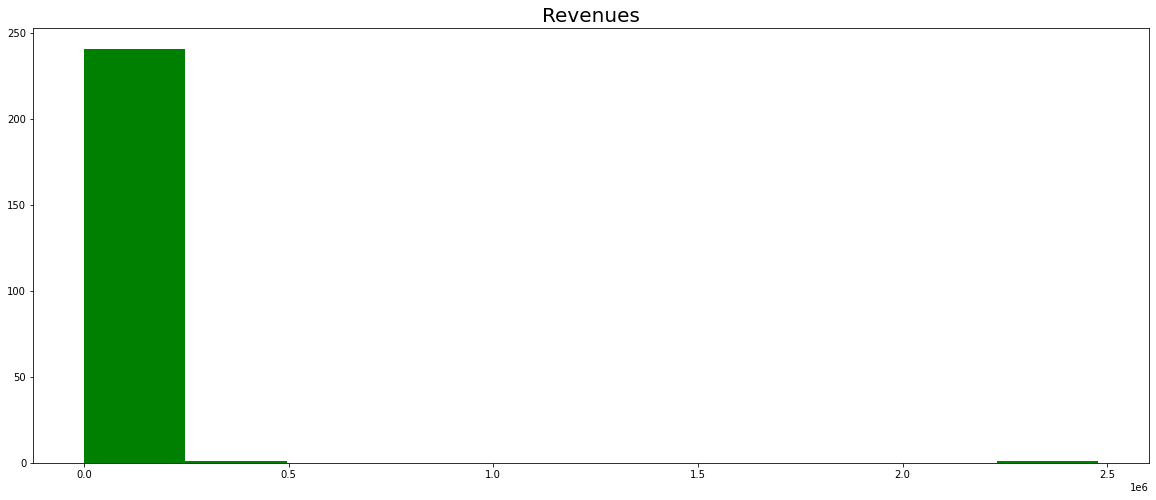

In [ ]:
fig = plt.figure(figsize=(20,8))
plt.title('Revenues', size=20)
plt.hist(np.asarray(seller_data['revenue']), bins=10, color='green')

In [ ]:
seller_data = seller_data.loc[seller_data['revenue']<250000]
seller_data

,id,sales,avg_price,revenue
0,LifeOfLazyCats,166,8.622000,1431.252000
1,Resinw0rldshop,0,8.236923,0.000000
2,DziwnaLogika,2,54.232813,108.465625
3,yunasoracrafts,199,14.649437,2915.237887
4,ZeitlosSchmuckDesign,1081,46.837000,50630.797000
...,...,...,...,...
238,Beldacci,177,26.236750,4643.904750
239,DerOekofroschLaden,15,4.710000,70.650000
240,ALEXASCHA,1296,26.548133,34406.380800
241,PIOFIORE,2,50.521250,101.042500


In [ ]:
seller_data.describe()

,sales,avg_price,revenue
count,241.000000,241.000000,241.000000
mean,320.132780,32.998591,5641.460447
std,1252.279335,63.631667,16319.552864
min,0.000000,2.464000,0.000000
25%,1.000000,10.788696,27.240000
50%,15.000000,19.452162,312.759000
75%,99.000000,35.004750,2939.857143
max,11929.000000,862.539167,150190.712195


In [ ]:
quartal_success = []
for revenue in seller_data['revenue']:
    if revenue >= 2939.857143:
        quartal_success.append(1)
    else:
        quartal_success.append(0)
seller_data['quartal_success'] = quartal_success
seller_data

,id,sales,avg_price,revenue,quartal_success
0,LifeOfLazyCats,166,8.622000,1431.252000,0
1,Resinw0rldshop,0,8.236923,0.000000,0
2,DziwnaLogika,2,54.232813,108.465625,0
3,yunasoracrafts,199,14.649437,2915.237887,0
4,ZeitlosSchmuckDesign,1081,46.837000,50630.797000,1
...,...,...,...,...,...
238,Beldacci,177,26.236750,4643.904750,1
239,DerOekofroschLaden,15,4.710000,70.650000,0
240,ALEXASCHA,1296,26.548133,34406.380800,1
241,PIOFIORE,2,50.521250,101.042500,0


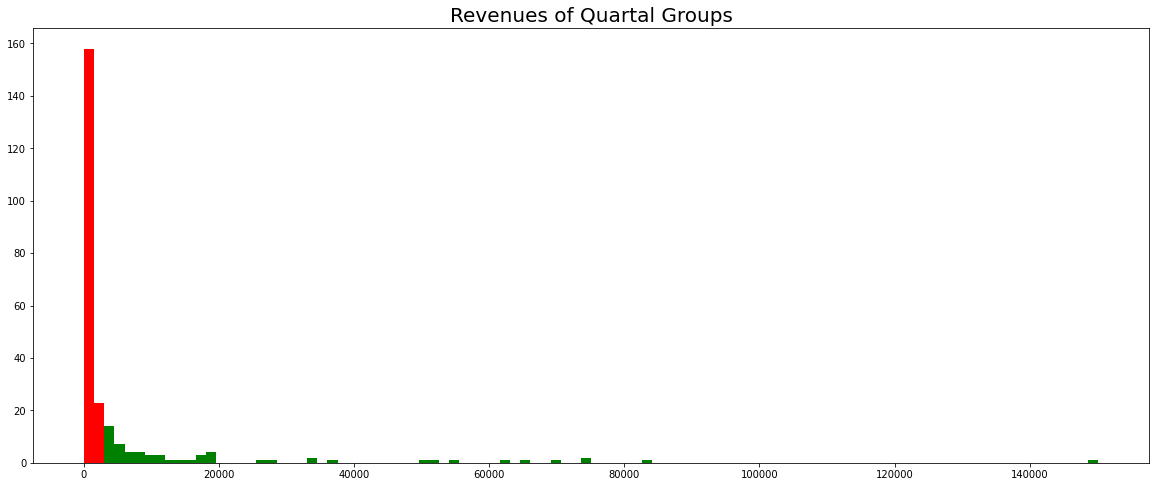

In [ ]:
zeros = seller_data.loc[seller_data['quartal_success']==0, 'revenue']
zero_bins = round((zeros.max()-zeros.min())/1500)
ones = seller_data.loc[seller_data['quartal_success']==1, 'revenue']
one_bins = round((ones.max()-ones.min())/1500)

fig = plt.figure(figsize=(20,8))
plt.title('Revenues of Quartal Groups', size=20)
plt.hist(zeros, zero_bins, facecolor='red')
plt.hist(ones, one_bins, facecolor='green')
plt.show()

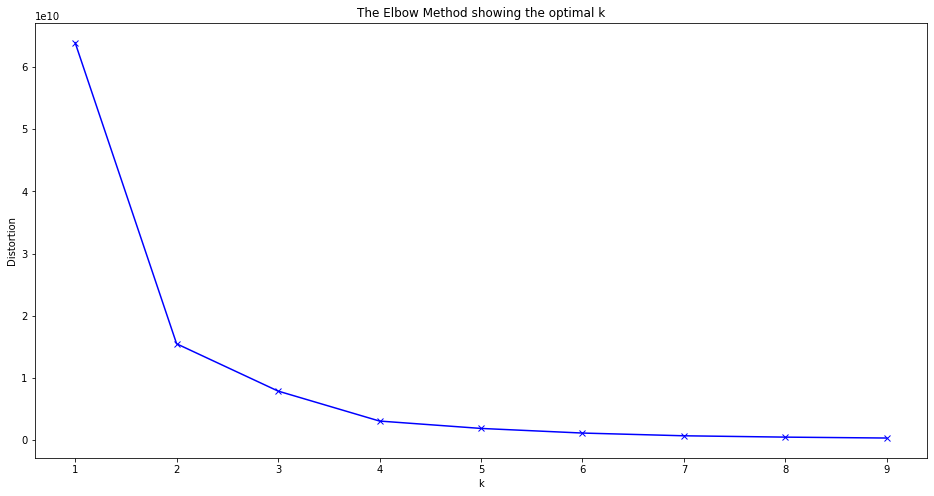

In [ ]:
show_elbow_plot(np.asarray(seller_data['revenue']).reshape(-1, 1) , 10)

In [ ]:
kmeans = KMeans(n_clusters=4).fit(np.asarray(seller_data['revenue']).reshape(-1, 1))
seller_data['cluster'] = kmeans.labels_
seller_data

,id,sales,avg_price,revenue,quartal_success,cluster
0,LifeOfLazyCats,166,8.622000,1431.252000,0,1
1,Resinw0rldshop,0,8.236923,0.000000,0,1
2,DziwnaLogika,2,54.232813,108.465625,0,1
3,yunasoracrafts,199,14.649437,2915.237887,0,1
4,ZeitlosSchmuckDesign,1081,46.837000,50630.797000,1,0
...,...,...,...,...,...,...
238,Beldacci,177,26.236750,4643.904750,1,1
239,DerOekofroschLaden,15,4.710000,70.650000,0,1
240,ALEXASCHA,1296,26.548133,34406.380800,1,3
241,PIOFIORE,2,50.521250,101.042500,0,1


In [ ]:
kmeans.cluster_centers_

array([[ 65287.4715715 ],
       [  1355.40740292],
       [150190.71219512],
       [ 21936.4008177 ]])

In [ ]:
cluster_success = []
for cluster in seller_data['cluster']:
    if cluster == 0 or cluster == 2:
        cluster_success.append(1)
    else:
        cluster_success.append(0)
seller_data['cluster_success'] = cluster_success
seller_data

,id,sales,avg_price,revenue,quartal_success,cluster,cluster_success
0,LifeOfLazyCats,166,8.622000,1431.252000,0,1,0
1,Resinw0rldshop,0,8.236923,0.000000,0,1,0
2,DziwnaLogika,2,54.232813,108.465625,0,1,0
3,yunasoracrafts,199,14.649437,2915.237887,0,1,0
4,ZeitlosSchmuckDesign,1081,46.837000,50630.797000,1,0,1
...,...,...,...,...,...,...,...
238,Beldacci,177,26.236750,4643.904750,1,1,0
239,DerOekofroschLaden,15,4.710000,70.650000,0,1,0
240,ALEXASCHA,1296,26.548133,34406.380800,1,3,0
241,PIOFIORE,2,50.521250,101.042500,0,1,0


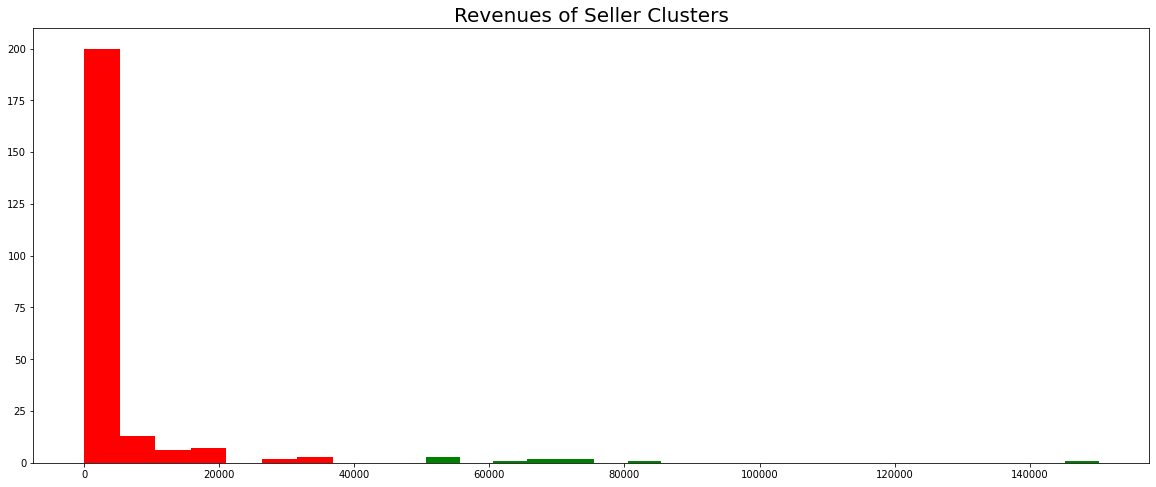

In [ ]:
zeros = seller_data.loc[seller_data['cluster_success']==0, 'revenue']
zero_bins = round((zeros.max()-zeros.min())/5000)
ones = seller_data.loc[seller_data['cluster_success']==1, 'revenue']
one_bins = round((ones.max()-ones.min())/5000)

fig = plt.figure(figsize=(20,8))
plt.title('Revenues of Seller Clusters', size=20)
plt.hist(zeros, zero_bins, facecolor='red')
plt.hist(ones, one_bins, facecolor='green')
plt.show()

In [ ]:
zeros_quartal = seller_data.loc[seller_data['quartal_success']==0].describe()
zeros_quartal

,sales,avg_price,revenue,quartal_success,cluster,cluster_success
count,181.000000,181.000000,181.000000,181.0,181.0,181.0
mean,27.900552,25.370154,480.425012,0.0,1.0,0.0
std,56.775200,30.057359,737.055308,0.0,0.0,0.0
min,0.000000,3.100000,0.000000,0.0,1.0,0.0
25%,1.000000,10.177000,11.315217,0.0,1.0,0.0
50%,6.000000,17.501389,99.108571,0.0,1.0,0.0
75%,23.000000,30.716471,628.727778,0.0,1.0,0.0
max,352.000000,300.608333,2939.857143,0.0,1.0,0.0


In [ ]:
ones_quartal = seller_data.loc[seller_data['quartal_success']==1].describe()
ones_quartal

,sales,avg_price,revenue,quartal_success,cluster,cluster_success
count,60.000000,60.000000,60.000000,60.0,60.000000,60.000000
mean,1201.700000,56.011041,21210.584009,1.0,1.366667,0.166667
std,2305.857113,114.004904,27449.758065,0.0,1.024557,0.375823
min,4.000000,2.464000,3004.796667,1.0,0.000000,0.000000
25%,140.500000,17.631606,4611.654435,1.0,1.000000,0.000000
50%,384.000000,30.264863,9494.908500,1.0,1.000000,0.000000
75%,1079.500000,54.479821,21191.975417,1.0,2.250000,0.000000
max,11929.000000,862.539167,150190.712195,1.0,3.000000,1.000000


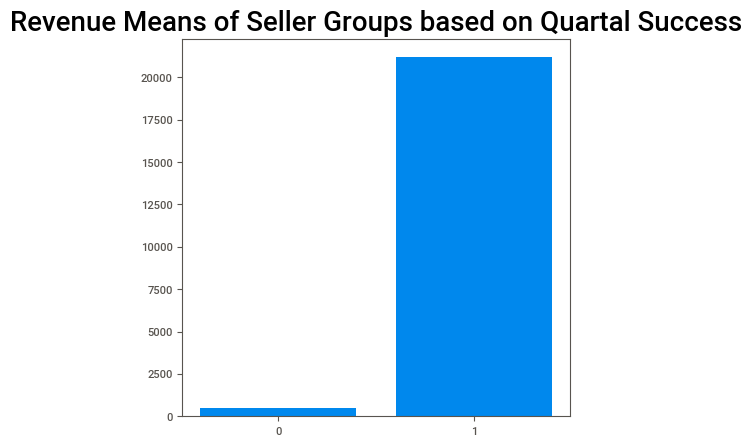

In [ ]:
plt.figure(figsize=(5,5))
plt.title('Revenue Means of Seller Groups based on Quartal Success', size=20)
plt.bar(['0','1'], [zeros_quartal['revenue']['mean'], ones_quartal['revenue']['mean']])
plt.show()

In [ ]:
zeros_cluster = seller_data.loc[seller_data['cluster_success']==0].describe()
zeros_cluster

,sales,avg_price,revenue,quartal_success,cluster,cluster_success
count,231.000000,231.000000,231.000000,231.000000,231.000000,231.0
mean,155.506494,32.634313,2691.835547,0.216450,1.129870,0.0
std,528.227733,64.600940,5898.695635,0.412719,0.493893,0.0
min,0.000000,2.464000,0.000000,0.000000,1.000000,0.0
25%,1.000000,10.720776,25.044722,0.000000,1.000000,0.0
50%,13.000000,18.805439,290.831200,0.000000,1.000000,0.0
75%,84.000000,33.673472,2277.935574,0.000000,1.000000,0.0
max,4867.000000,862.539167,36849.002625,1.000000,3.000000,0.0


In [ ]:
ones_cluster = seller_data.loc[seller_data['cluster_success']==1].describe()
ones_cluster

,sales,avg_price,revenue,quartal_success,cluster,cluster_success
count,10.000000,10.000000,10.000000,10.0,10.000000,10.0
mean,4123.000000,41.413425,73777.795634,1.0,0.200000,1.0
std,4233.657389,35.219723,28830.047943,0.0,0.632456,0.0
min,1006.000000,4.500750,50630.797000,1.0,0.000000,1.0
25%,1143.250000,13.295449,56872.338375,1.0,0.000000,1.0
50%,2433.000000,33.950679,68014.470192,1.0,0.000000,1.0
75%,4369.500000,61.888492,74040.414852,1.0,0.000000,1.0
max,11929.000000,111.087805,150190.712195,1.0,2.000000,1.0


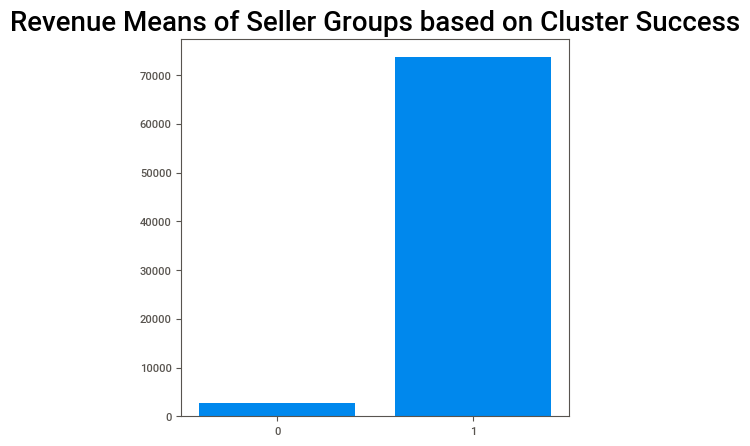

In [ ]:
plt.figure(figsize=(5,5))
plt.title('Revenue Means of Seller Groups based on Cluster Success', size=20)
plt.bar(['0','1'], [zeros_cluster['revenue']['mean'], ones_cluster['revenue']['mean']])
plt.show()

In [ ]:
seller_data.to_csv('data/seller_data_success.csv')

In [ ]:
seller_data = pd.read_csv('data/seller_data_success.csv').drop(labels='Unnamed: 0', axis=1)
report = sweetviz.analyze([seller_data, 'Data'])
report.show_html()


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Analysing Product Types

Now I'm doing an exploratory data analysis for seller data combined with product types and also analyse key parameters of different product type seller groups. 

In [ ]:
seller_data = pd.read_csv('data/seller_data_success.csv').drop(labels='Unnamed: 0', axis=1)
product_data = pd.read_csv('data/product_data_preped.csv').drop(labels='Unnamed: 0', axis=1)

In [ ]:
product_types = {'necklace': [],
                'earring': [],
                ' ring ': [],
                'keychain': []}

for seller_id in seller_data['id']:
    product_texts = ''
    for text in product_data.loc[np.where(product_data['seller_id']==seller_id), 'full_text']:
        product_texts = product_texts + ' ' + text
    for product_type in product_types.keys():
        if product_type in product_texts:
            product_types[product_type].append(1)
        else:
            product_types[product_type].append(0)
            
for product_type in product_types:
    seller_data[product_type] = product_types[product_type]
    
seller_data = seller_data.rename(columns={' ring ': 'ring'})
other_product = seller_data['necklace'] + seller_data['earring'] + seller_data['ring'] + seller_data['keychain']
other_product = other_product == 0
seller_data['other_product'] = other_product
seller_data['other_product'] = seller_data['other_product'].astype(int)

seller_data

,id,sales,avg_price,revenue,quartal_success,cluster,cluster_success,necklace,earring,ring,keychain,other_product
0,LifeOfLazyCats,166,8.622000,1431.252000,0,1,0,0,0,0,0,1
1,Resinw0rldshop,0,8.236923,0.000000,0,1,0,0,0,0,1,0
2,DziwnaLogika,2,54.232813,108.465625,0,1,0,0,0,0,1,0
3,yunasoracrafts,199,14.649437,2915.237887,0,1,0,0,0,0,1,0
4,ZeitlosSchmuckDesign,1081,46.837000,50630.797000,1,0,1,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
236,Beldacci,177,26.236750,4643.904750,1,1,0,1,1,0,0,0
237,DerOekofroschLaden,15,4.710000,70.650000,0,1,0,0,1,0,0,0
238,ALEXASCHA,1296,26.548133,34406.380800,1,3,0,1,1,1,0,0
239,PIOFIORE,2,50.521250,101.042500,0,1,0,1,1,0,0,0


In [ ]:
product_types = ['necklace','earring','ring','keychain','other_product']
for product_type in product_types:
    print(f'number of {product_type} sellers: ' + str(len(seller_data.loc[seller_data[product_type]==1])))

number of necklace sellers: 113
number of earring sellers: 114
number of ring sellers: 65
number of keychain sellers: 81
number of other_product sellers: 42


In [ ]:
#Note: 
#In this case relative frequency of quartal and cluster success are equal to their means

for product_type in product_types:
    print(product_type.upper())
    print(seller_data.loc[seller_data[product_type]==1, ['revenue', 'quartal_success', 'cluster_success']].describe())
    print()

NECKLACE
             revenue  quartal_success  cluster_success
count     113.000000       113.000000       113.000000
mean     7751.705583         0.318584         0.053097
std     20278.456648         0.468003         0.225226
min         0.000000         0.000000         0.000000
25%        56.159167         0.000000         0.000000
50%       794.869444         0.000000         0.000000
75%      4334.161500         1.000000         0.000000
max    150190.712195         1.000000         1.000000

EARRING
             revenue  quartal_success  cluster_success
count     114.000000       114.000000       114.000000
mean     7817.630591         0.315789         0.061404
std     20452.948989         0.466882         0.241129
min         0.000000         0.000000         0.000000
25%        70.581786         0.000000         0.000000
50%       716.239000         0.000000         0.000000
75%      4383.949304         1.000000         0.000000
max    150190.712195         1.000000         1

In [ ]:
seller_data.to_csv('data/seller_data_product_selection.csv')

In [ ]:
seller_data = pd.read_csv('data/seller_data_product_selection.csv').drop(labels='Unnamed: 0', axis=1)
report = sweetviz.analyze([seller_data, 'Data'], target_feat='quartal_success')
report.show_html()


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
seller_data = pd.read_csv('data/seller_data_product_selection.csv').drop(labels='Unnamed: 0', axis=1)
report = sweetviz.analyze([seller_data, 'Data'], target_feat='cluster_success')
report.show_html()


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Data Mining for Product Type Selection

    To answer the question "Which product should we sell?" I am investigating dependencies between selling 
    a spesific product type and beeing in a success group for sellers.
    I am doing A/B tests using chi square test for each product type.
    
    In the test:
    Independent variables are if seller sells the spesific product type or not.
    Dependent variables are if seller is successful based on quartal or cluster success or not.
    
    If we can find any dependency, we can tell if sellers selling a spesific product type (or not) are more 
    likely to be successful based on our success groups.

In [ ]:
seller_data = pd.read_csv('data/seller_data_product_selection.csv').drop(labels='Unnamed: 0', axis=1)

In [ ]:
def show_ab_tests(df, independent_vars, measure):
    rel_freqs_1 = []
    rel_freqs_0 = []
    for ivar in independent_vars:
        rel_freqs_1.append(df.loc[df[ivar]==1, measure].mean())
        rel_freqs_0.append(df.loc[df[ivar]==0, measure].mean())

    ivars_df = pd.DataFrame(data={'ivar':independent_vars,
                                   'rel_freq_1':rel_freqs_1,
                                   'rel_freq_0':rel_freqs_0})
    ivars_df = ivars_df.sort_values('rel_freq_1', ascending=False)

    x = []
    for ivar in ivars_df['ivar']:
        x.append(ivar+' 1')
        x.append(ivar+' 0')

    y1 = []
    for val in ivars_df['rel_freq_1']:
        y1.append(val)
        y1.append(0)

    y0 = []
    for val in ivars_df['rel_freq_0']:
        y0.append(0)
        y0.append(val)

    print(f'*Seller groups: {independent_vars}')
    plt.figure(figsize=(20,10))
    plt.title(f'{measure} Relative Frequency of Seller Groups*', size=25)
    plt.xlabel('Group', fontsize=15)
    plt.ylabel('Relative Frequency', fontsize=15)
    plt.tick_params(axis='both', labelsize=15)
    plt.xticks(rotation='vertical')
    plt.bar(x, y1)
    plt.bar(x, y0)
    plt.hlines(df[measure].mean(), -0.4, len(x)-0.6, color='black', linestyle='dashed')
    plt.show()
    return ivars_df['ivar']

In [ ]:
def show_ab_test(df, independent_var, measure):
    plt.figure(figsize=(7,8))
    plt.title(f'{measure} Relative Frequency of Ring Seller Groups According to {independent_var}', size=25)
    plt.xlabel(independent_var, fontsize=15)
    plt.ylabel('Relative Frequency', fontsize=15)
    plt.tick_params(axis='both', labelsize=15)
    plt.bar('True', df.loc[df[independent_var]==1, measure].mean())
    plt.bar('False',df.loc[df[independent_var]==0, measure].mean())
    plt.hlines(df[measure].mean(), -0.4, 1.4, color='black', linestyle='dashed')
    plt.show()

In [ ]:
def do_ab_tests(df, independent_vars, measure):
    for ivar in independent_vars:
        print(ivar.upper())
        ct = pd.crosstab(df[ivar], df[measure])
        print(ct)
        (chi2, p, dof, _) = stats.chi2_contingency(ct.values)
        print(f'chi2 is {chi2} with a degrees of freedom {dof}')
        print(f'p-value: {p}')
        if p < 0.05:
            print('significant')
        else:
            print('not significant')
        print()
        
def do_ab_test(df, independent_var, measure):
    do_ab_tests(df, [independent_var], measure)

*Seller groups: ['necklace', 'earring', 'ring', 'keychain', 'other_product']


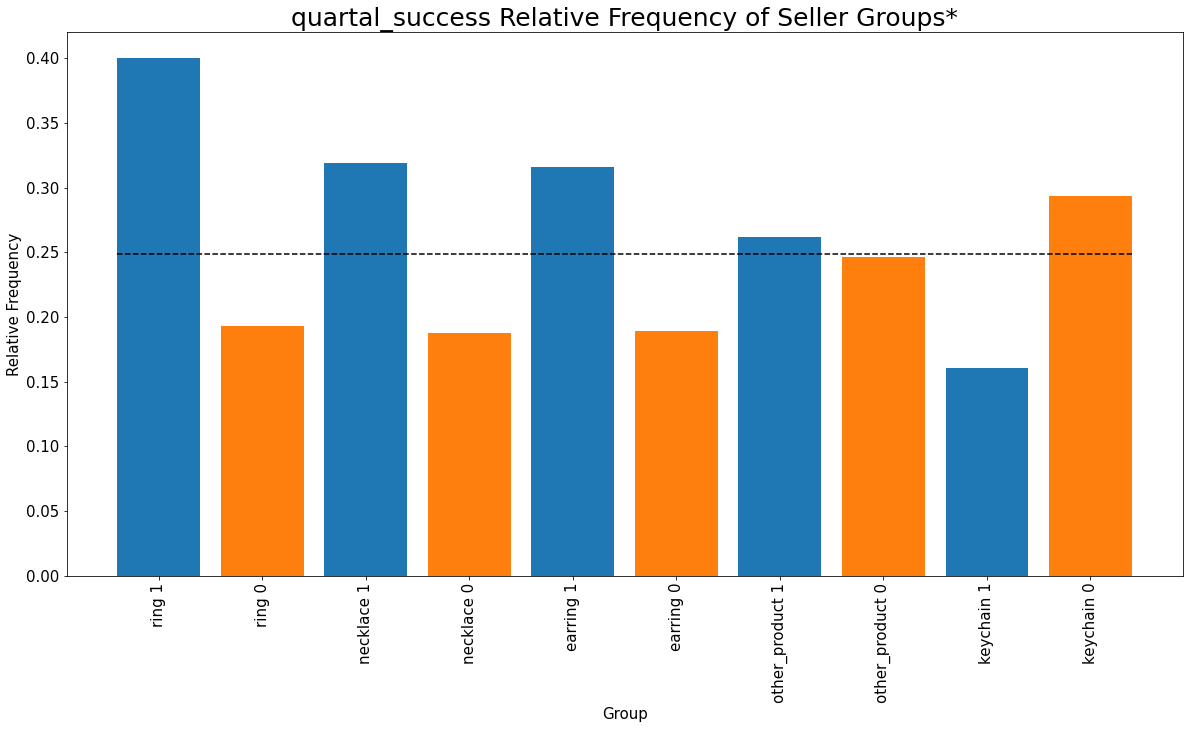

In [ ]:
product_types = ['necklace','earring','ring','keychain','other_product']
ordered_types = show_ab_tests(seller_data, product_types, 'quartal_success')

In [ ]:
do_ab_tests(seller_data, ordered_types, 'quartal_success')

RING
quartal_success    0   1
ring                    
0                142  34
1                 39  26
chi2 is 9.78109127491983 with a degrees of freedom 1
p-value: 0.0017631563883844749
significant

NECKLACE
quartal_success    0   1
necklace                
0                104  24
1                 77  36
chi2 is 4.836599843301819 with a degrees of freedom 1
p-value: 0.027861778199364425
significant

EARRING
quartal_success    0   1
earring                 
0                103  24
1                 78  36
chi2 is 4.510867700266386 with a degrees of freedom 1
p-value: 0.03368015071413997
significant

OTHER_PRODUCT
quartal_success    0   1
other_product           
0                150  49
1                 31  11
chi2 is 0.00029272744940171577 with a degrees of freedom 1
p-value: 0.986349435923782
not significant

KEYCHAIN
quartal_success    0   1
keychain                
0                113  47
1                 68  13
chi2 is 4.419200189917126 with a degrees of freedom 1
p-value:

*Seller groups: ['necklace', 'earring', 'ring', 'keychain', 'other_product']


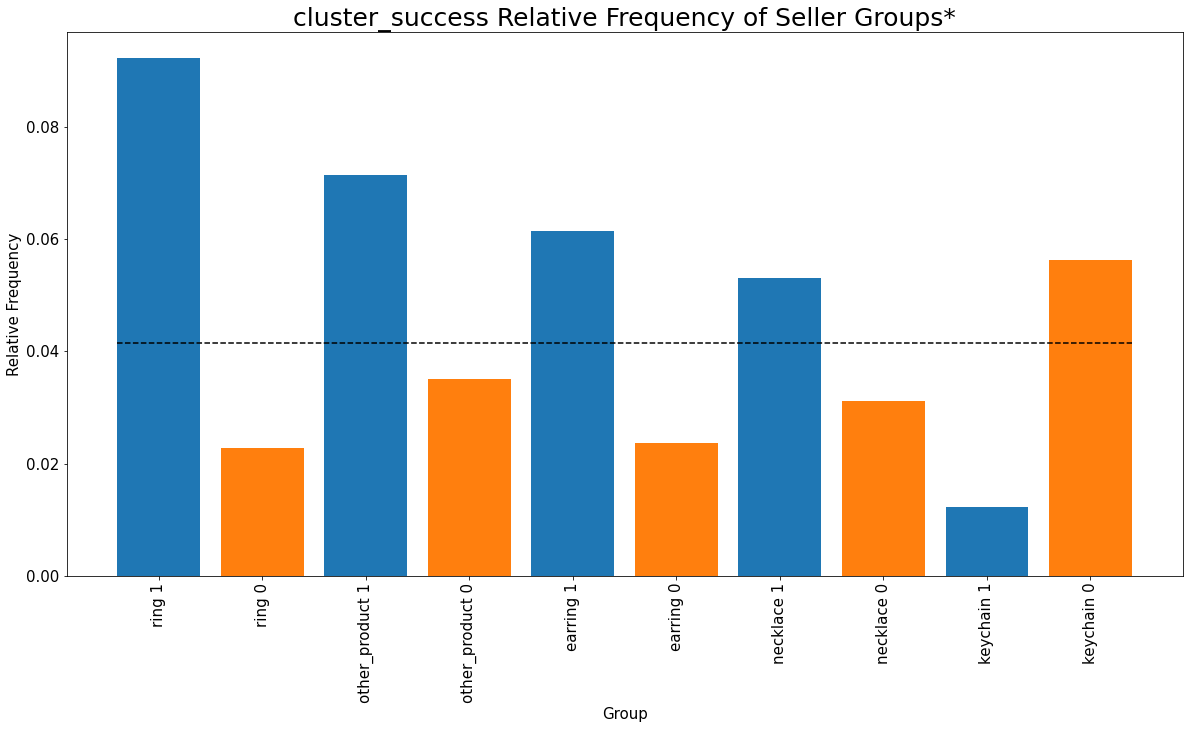

In [ ]:
ordered_types = show_ab_tests(seller_data, product_types, 'cluster_success')

In [ ]:
do_ab_tests(seller_data, ordered_types, 'cluster_success')

RING
cluster_success    0  1
ring                   
0                172  4
1                 59  6
chi2 is 4.161306884403475 with a degrees of freedom 1
p-value: 0.04135748186410451
significant

OTHER_PRODUCT
cluster_success    0  1
other_product          
0                192  7
1                 39  3
chi2 is 0.4157463388888371 with a degrees of freedom 1
p-value: 0.5190672060195967
not significant

EARRING
cluster_success    0  1
earring                
0                124  3
1                107  7
chi2 is 1.3107943519619858 with a degrees of freedom 1
p-value: 0.2522508839785611
not significant

NECKLACE
cluster_success    0  1
necklace               
0                124  4
1                107  6
chi2 is 0.27568311861902817 with a degrees of freedom 1
p-value: 0.599544715316374
not significant

KEYCHAIN
cluster_success    0  1
keychain               
0                151  9
1                 80  1
chi2 is 1.6192912006974503 with a degrees of freedom 1
p-value: 0.2031906478452

    • Ring sellers has significantly higher relative frequency of quartal or cluster
      success.
      In other words they are more likely to be successful in both quartal and cluster success measures.
    • Necklace and earring sellers has significantly higher relative frequency of quartal success.
      In other words they are more likely to be successful in quartal success measure.
    • Ring has also the highest success frequency in both cases with 40% and 9,23%.

    When I think about the success of ring sellers two possiblities come to my mind:
        1. There are less ring sellers than the other product sellers. So the low competition in this market 
           may have caused the success of ring sellers.
        2. The successful sellers in other product types may be expanding their market by selling rings as 
           well.
    
    Of course they are not the only possibilities, but I think they are the most likely ones to be.

    So I want to try to test the second possibility since we are new sellers and don't want to expand our 
    market, but enter in a market with good opportunities.
    If sellers are coming to ring market to expand their businesses, then these sellers should be also selling
    other products.
    If these sellers are not also selling other products, then are not coming to ring market to expand their 
    businesses.

    Therefore I will test the independence of variables and see if relative frequency of only ring sellers are 
    significantly lower than other successful product types.

Number of only necklace sellers: 31
Ratio of only necklace sellers to necklace sellers: 0.2743362831858407

Number of only earring sellers: 27
Ratio of only earring sellers to earring sellers: 0.23684210526315788

Number of only ring sellers: 15
Ratio of only ring sellers to ring sellers: 0.23076923076923078



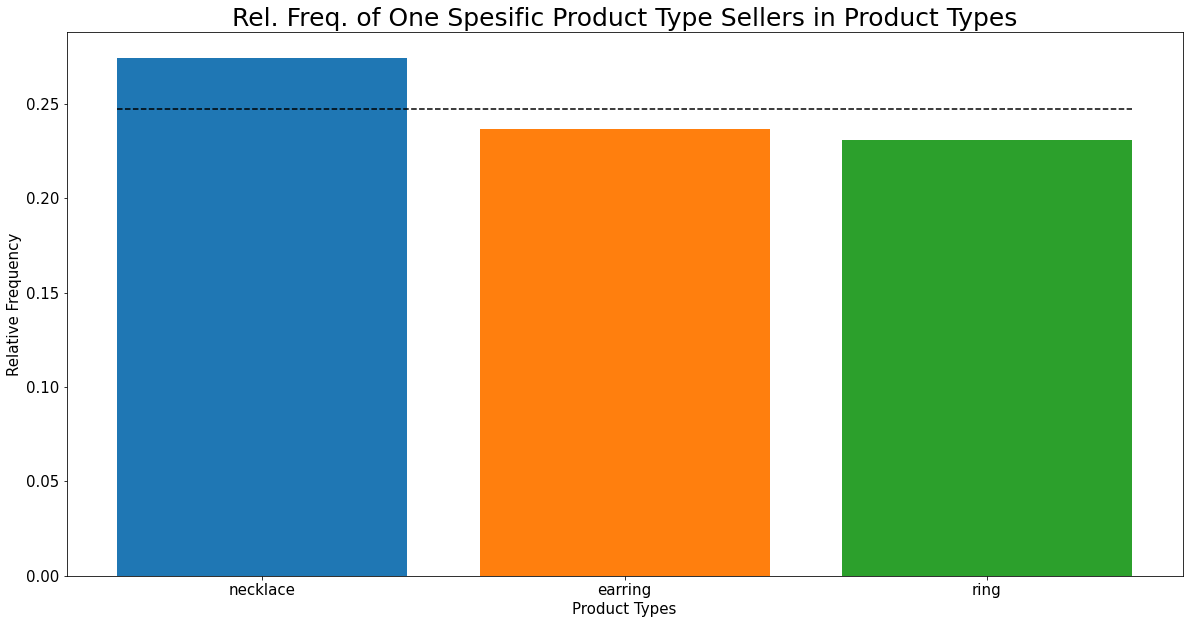

In [ ]:
plt.figure(figsize=(20,10))
plt.title('Rel. Freq. of One Spesific Product Type Sellers in Product Types', size=25)
plt.xlabel('Product Types', fontsize=15)
plt.ylabel('Relative Frequency', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
abs_freqs = []
sizes = []
rel_freqs = []
product_types = ['necklace','earring','ring']
for product_type in product_types:
    others = [el for el in product_types if el != product_type]
    only = seller_data.loc[(seller_data[product_type]==1) &
                      (seller_data[others[0]]==0) &
                      (seller_data[others[1]]==0)]
    all_ = seller_data.loc[seller_data[product_type]==1]
    abs_freq = len(only)
    abs_freqs.append(abs_freq)
    size = len(all_)
    sizes.append(size)
    rel_freq = abs_freq/size
    rel_freqs.append(rel_freq)
    print(f'Number of only {product_type} sellers: {len(only)}')
    print(f'Ratio of only {product_type} sellers to {product_type} sellers: {rel_freq}')
    print()
    plt.bar([product_type], [rel_freq])
plt.hlines(np.asarray(rel_freqs).mean(), -0.4, 2.4, color='black', linestyle='dashed')
plt.show()

In [ ]:
data = np.asarray([abs_freqs, sizes])
data[1] = data[1] - data[0]
data = data.T
spesific_product_ct = pd.DataFrame(data=data, index=product_types, columns=['only spesific', 'others too'])
spesific_product_ct

,only spesific,others too
necklace,31,82
earring,27,87
ring,15,50


In [ ]:
(chi2, p, dof, _) = stats.chi2_contingency(spesific_product_ct.values)
print(f'chi2 is {chi2} with a degrees of freedom {dof}')
print(f'p-value: {p}')
if p < 0.05:
    print('significant')
else:
    print('not significant')

chi2 is 0.5904004394921955 with a degrees of freedom 2
p-value: 0.7443825324628806
not significant


    We couldn't falsify the independence of variables.
    There is not a significant difference between different product types' only product seller measures.
    There is no evidence showing the second possibility is statistically significant.

    Because of that I will continue with ring sellers, which has the significantly highest success performance.
    I will investigate the features of ring products.

## Analysing Product Feautures from Text

    I am analysing the full text columns of products using nltk to find out which words are used most to 
    describe ring products. 
    Based on this analysis I am analysing key parameters of seller data depending on if seller sells product(s) 
    with selected feature.

In [ ]:
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords

In [ ]:
seller_data = pd.read_csv('data/seller_data_product_selection.csv').drop(labels='Unnamed: 0', axis=1)
product_data = pd.read_csv('data/product_data_preped.csv').drop(labels='Unnamed: 0', axis=1)

In [ ]:
esw = stopwords.words('english')
esw.append('would')

In [ ]:
word_pattern = re.compile('^\w+$')

In [ ]:
def get_text_counter(text):
    tokens = WordPunctTokenizer().tokenize(PorterStemmer().stem(text))
    tokens = list(map(lambda x: x.lower(), tokens))
    tokens = [token for token in tokens if re.match(word_pattern, token) and token not in esw]
    return collections.Counter(tokens), len(tokens)

In [ ]:
def get_word_frequencies(counter, size):
    abs_freq = np.array([counter[el] for el in counter])
    rel_freq = abs_freq / size
    index = [el for el in counter]
    word_freqs = pd.DataFrame(data = {'Absolute Frequency': abs_freq, 
                                     'Relative Frequency': rel_freq},
                             index = index)
    word_freqs.index.name = 'Word Frequencies'
    word_freqs = word_freqs.sort_values('Absolute Frequency', ascending = False)
    return word_freqs

In [ ]:
def get_all_text(product_data):
    all_text = ''
    for text in product_data['full_text']:
        all_text = all_text + ' ' + text
    return all_text

In [ ]:
all_text = get_all_text(product_data)

counter, size = get_text_counter(all_text)
all_text_freqs = get_word_frequencies(counter, size)
all_text_freqs

,Absolute Frequency,Relative Frequency
Word Frequencies,,
handmade,6537,0.015174
resin,6198,0.014388
materials,4096,0.009508
made,3661,0.008498
pendant,3453,0.008016
...,...,...
molding,1,0.000002
serene,1,0.000002
heads,1,0.000002


In [ ]:
all_text_freqs.to_csv('data/all_text_freqs.csv')

In [ ]:
ring_products = []
product_data['full_text'] = product_data['full_text'].str.lower()
for text in product_data['full_text']:
    if ' ring ' in text:
        ring_products.append(True)
    else:
        ring_products.append(False)
ring_data = product_data.loc[ring_products]
ring_data

,name,description,details,price,seller_id,full_text
106,New Corrugated cardboard resin ring/stainless ...,Unique colorful twisted handmade ring. Corruga...,"Handmade item, Size: 8 1/4 US, Materials: Wood...",65.56,ZeitlosSchmuckDesign,new corrugated cardboard resin ring/stainless ...
107,New! New! New! Aurora Borealis/Northern Lights...,Unique twisted handmade ring. From a beautiful...,"Handmade item, Size: 8 3/4 US, Materials: Plas...",90.91,ZeitlosSchmuckDesign,new! new! new! aurora borealis/northern lights...
124,Letter keychain made of epoxy resin | Gift Gir...,Keychainletters ⭐️May we introduce? Our new ke...,"Handmade, Materials: Epoxy, Resin, Key ring wi...",7.42,Oliverley,letter keychain made of epoxy resin | gift gir...
251,Ring finger ring statement rings made of resin...,Description,NaN,14.87,LaDisDesign,ring finger ring statement rings made of resin...
390,Letter Personalized Keychain,Beautiful resin keychain with your desired let...,"Handmade, Length: 4 centimeters",8.67,blondjuwel,letter personalized keychain ; beautiful resin...
...,...,...,...,...,...,...
6042,Resin Ring Gross Chartreuse Lind Green Stateme...,Round delicacy for your fingers - an adjustabl...,"Handmade item, Materials: Plastic, Silver, Gem...",4.86,ALEXASCHA,resin ring gross chartreuse lind green stateme...
6043,Vintage Ring Red Violet Oval Big Plastic Polar...,"Adjustable ring with oval ""Green Apple Gum"" be...","Handmade item, Materials: Glass, Plastic, Silv...",9.72,ALEXASCHA,vintage ring red violet oval big plastic polar...
6057,Minimalist ring small glass copper amber gold,The size-adjustable ring is provided with a sm...,"Handmade item, Materials: Glass, Stainless ste...",12.96,ALEXASCHA,minimalist ring small glass copper amber gold ...
6063,Geometric Jewelry Glass Ring Minimalist Brown ...,This statement ring for skilful accents is adj...,"Handmade item, Materials: Glass, Gem color: Br...",19.87,ALEXASCHA,geometric jewelry glass ring minimalist brown ...


In [ ]:
ring_text = get_all_text(ring_data)

counter, size = get_text_counter(ring_text)
ring_text_freqs = get_word_frequencies(counter, size)
ring_text_freqs

,Absolute Frequency,Relative Frequency
Word Frequencies,,
ring,1416,0.041304
silver,544,0.015868
resin,459,0.013389
handmade,442,0.012893
size,425,0.012397
...,...,...
massive,1,0.000029
unworn,1,0.000029
picturelength,1,0.000029


In [ ]:
ring_text_freqs.to_csv('data/ring_word_freqs.csv')

In [ ]:
seller_ring_join = seller_data.loc[seller_data['ring'] == 1].join(product_data.set_index('seller_id'), on='id')
seller_ring_join = seller_ring_join[['id', 'quartal_success', 'cluster_success', 'full_text']]
seller_ring_join

,id,quartal_success,cluster_success,full_text
4,ZeitlosSchmuckDesign,1,1,aurora borealis/northern lights/wood resin nec...
4,ZeitlosSchmuckDesign,1,1,wood resin necklace/resin wood necklace/gift/e...
4,ZeitlosSchmuckDesign,1,1,hei toki resin necklace/blacklight/hei toki wo...
4,ZeitlosSchmuckDesign,1,1,paua shell/paua shell/ wood resin necklace/woo...
4,ZeitlosSchmuckDesign,1,1,bestseller/resin wood necklace/dandelion/turqu...
...,...,...,...,...
238,ALEXASCHA,1,0,geometric jewelry glass ring minimalist brown ...
238,ALEXASCHA,1,0,silver earrings dark blue basic ; silver earri...
238,ALEXASCHA,1,0,romantic shell necklace / glass bead by swarow...
238,ALEXASCHA,1,0,small gift for advent calendar black ring oval...


In [ ]:
ring_success = {'quartal': [], 'cluster': []}

ring_success['quartal'].append(seller_ring_join.loc[seller_ring_join['quartal_success']==0])
ring_success['quartal'].append(seller_ring_join.loc[seller_ring_join['quartal_success']==1])
ring_success['cluster'].append(seller_ring_join.loc[seller_ring_join['cluster_success']==0])
ring_success['cluster'].append(seller_ring_join.loc[seller_ring_join['cluster_success']==1])

for key in ring_success.keys():
    for i in range(2):
        text = get_all_text(ring_success[key][i])
        counter, size = get_text_counter(text)
        text_freqs = get_word_frequencies(counter, size)
        text_freqs.to_csv(f'data/ring_{key}_success_word_freqs_{i}.csv')

#### Product Features to Analyse:

    • Material: gold, silver, bronze, metal, wood, gem, nickel, brass, 
      leather, glass, stone, cabochon, crystal, bead, copper, plastic, flower/leaf
      (otherwords to search in text: flower, flowers, leaf)
    • Color: white, black, red, green, blue, yellow, brown, purple, pink, orange,
    turquoise, brown
    • Theme: vintage, hippie, minimal
    • Personalized (other words to search in text: custom, customized, individual)
    • Transparent
    • Matt
    • Waterproof (other words to search in text: washable) 
    • Polished
    • Plated
    • Adjustable

In [ ]:
one_word_features = [
    'gold', 'silver', 'bronze', 'metal', 'wood', 'gem', 'nickel', 'brass', 
    'leather', 'glass', 'stone', 'cabochon', 'crystal', 'bead', 'copper', 'plastic',
    'white', 'black', 'red', 'green', 'blue', 'yellow', 'brown', 'purple', 'pink', 
    'orange','turquoise',
    'vintage', 'hippie', 'minimal',
    'transparent',
    'matt',
    'polished',
    'plated',
    'adjustable'
]

multiple_word_features = {'personalized': ['personalized', 'custom', 'customized', 'individual'],
    'flower': ['flower', 'leaf'],
    'waterproof': ['waterproof', 'water proof','water resistant', 'waterresistant','washable'] }

In [ ]:
for feature in one_word_features:
    seller_ring_join[feature] = seller_ring_join['full_text'].str.contains(feature).astype(int)

for feature in multiple_word_features.keys():
    column_values = np.zeros(seller_ring_join.shape[0])
    for word in multiple_word_features[feature]:
        column_values = column_values + seller_ring_join['full_text'].str.contains(word).astype(int)
    seller_ring_join[feature] = column_values
    
seller_ring_join

,id,quartal_success,cluster_success,full_text,gold,silver,bronze,metal,wood,gem,...,hippie,minimal,transparent,matt,polished,plated,adjustable,personalized,flower,waterproof
4,ZeitlosSchmuckDesign,1,1,aurora borealis/northern lights/wood resin nec...,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.0,0.0,0.0
4,ZeitlosSchmuckDesign,1,1,wood resin necklace/resin wood necklace/gift/e...,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.0,0.0,0.0
4,ZeitlosSchmuckDesign,1,1,hei toki resin necklace/blacklight/hei toki wo...,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0.0,0.0,0.0
4,ZeitlosSchmuckDesign,1,1,paua shell/paua shell/ wood resin necklace/woo...,0,0,0,0,1,0,...,1,0,0,0,0,0,1,0.0,0.0,0.0
4,ZeitlosSchmuckDesign,1,1,bestseller/resin wood necklace/dandelion/turqu...,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,ALEXASCHA,1,0,geometric jewelry glass ring minimalist brown ...,0,1,0,0,0,1,...,0,1,1,0,0,1,1,0.0,0.0,0.0
238,ALEXASCHA,1,0,silver earrings dark blue basic ; silver earri...,0,1,0,0,0,0,...,0,1,0,1,0,1,0,0.0,0.0,0.0
238,ALEXASCHA,1,0,romantic shell necklace / glass bead by swarow...,1,1,0,1,0,0,...,0,0,0,0,0,1,1,1.0,0.0,0.0
238,ALEXASCHA,1,0,small gift for advent calendar black ring oval...,0,1,0,0,0,0,...,0,0,0,0,0,1,1,0.0,0.0,0.0


In [ ]:
seller_feature_selection = seller_ring_join.drop(labels='full_text', axis=1)
seller_feature_selection = seller_feature_selection.pivot_table(index='id', aggfunc='sum')
for column in seller_feature_selection.columns:
    seller_feature_selection[column] = [1 if el>0 else 0 for el in seller_feature_selection[column]]

seller_feature_selection

,adjustable,bead,black,blue,brass,bronze,brown,cabochon,cluster_success,copper,...,red,silver,stone,transparent,turquoise,vintage,waterproof,white,wood,yellow
id,,,,,,,,,,,,,,,,,,,,,
ALEXASCHA,1,1,1,1,0,0,1,0,0,1,...,1,1,1,1,1,1,0,1,0,1
AlluringJewelryDE,1,0,1,1,1,0,0,0,0,0,...,1,1,1,0,0,0,0,1,0,0
AngiWoodDesign,0,0,1,1,1,0,1,0,0,1,...,1,1,0,1,0,0,0,1,1,1
AnnaBlumenkind,1,1,1,1,0,1,1,1,0,0,...,1,1,1,0,1,0,0,1,1,1
Ardoriacrafts,0,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lifeoflone,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
mimitinkers,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
ranitasart,1,1,1,1,0,0,0,1,0,0,...,1,1,1,0,0,0,0,0,1,0


In [ ]:
multiple_word_features_ = list(multiple_word_features.keys())
multiple_word_features_.remove('flower')
new_col_order = ['quartal_success', 'cluster_success', 'flower'] + one_word_features + multiple_word_features_ 
seller_feature_selection = seller_feature_selection[new_col_order]

seller_feature_selection

,quartal_success,cluster_success,flower,gold,silver,bronze,metal,wood,gem,nickel,...,vintage,hippie,minimal,transparent,matt,polished,plated,adjustable,personalized,waterproof
id,,,,,,,,,,,,,,,,,,,,,
ALEXASCHA,1,0,1,1,1,0,1,0,1,1,...,1,1,1,1,1,0,1,1,1,0
AlluringJewelryDE,0,0,1,1,1,0,1,0,0,0,...,0,0,1,0,0,1,1,1,1,0
AngiWoodDesign,1,0,0,1,1,0,1,1,0,0,...,0,0,0,1,0,1,0,0,1,0
AnnaBlumenkind,1,0,1,1,1,1,1,1,0,0,...,0,1,0,0,0,0,0,1,1,0
Ardoriacrafts,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lifeoflone,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
mimitinkers,0,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
ranitasart,1,0,1,1,1,0,1,1,1,0,...,0,1,1,0,0,0,0,1,1,0


In [ ]:
features = list(seller_feature_selection.columns)
features.remove('quartal_success')
features.remove('cluster_success')
for feature in features:
    feature_true = seller_feature_selection.loc[seller_feature_selection[feature]==1, 
                                       ['quartal_success', 'cluster_success']]
    feature_false = seller_feature_selection.loc[seller_feature_selection[feature]==0, 
                                       ['quartal_success', 'cluster_success']]
    true_size = feature_true.shape[0]
    false_size = feature_false.shape[0]
    total_size = seller_feature_selection.shape[0]
    print(feature + ' is true')
    print(f'absolute frequency:  {true_size}, relative_frequency {true_size/total_size}')
    print(feature_true.describe())
    print(feature + ' is false')
    print(f'absolute frequency:  {false_size}, relative_frequency {false_size/total_size}')
    print(feature_false.describe())
    print()

flower is true
absolute frequency:  53, relative_frequency 0.8153846153846154
       quartal_success  cluster_success
count        53.000000        53.000000
mean          0.396226         0.113208
std           0.493793         0.319878
min           0.000000         0.000000
25%           0.000000         0.000000
50%           0.000000         0.000000
75%           1.000000         0.000000
max           1.000000         1.000000
flower is false
absolute frequency:  12, relative_frequency 0.18461538461538463
       quartal_success  cluster_success
count        12.000000             12.0
mean          0.416667              0.0
std           0.514929              0.0
min           0.000000              0.0
25%           0.000000              0.0
50%           0.000000              0.0
75%           1.000000              0.0
max           1.000000              0.0

gold is true
absolute frequency:  52, relative_frequency 0.8
       quartal_success  cluster_success
count        52.0000

       quartal_success  cluster_success
count        42.000000        42.000000
mean          0.333333         0.119048
std           0.477119         0.327770
min           0.000000         0.000000
25%           0.000000         0.000000
50%           0.000000         0.000000
75%           1.000000         0.000000
max           1.000000         1.000000

bead is true
absolute frequency:  29, relative_frequency 0.4461538461538462
       quartal_success  cluster_success
count        29.000000        29.000000
mean          0.586207         0.137931
std           0.501230         0.350931
min           0.000000         0.000000
25%           0.000000         0.000000
50%           1.000000         0.000000
75%           1.000000         0.000000
max           1.000000         1.000000
bead is false
absolute frequency:  36, relative_frequency 0.5538461538461539
       quartal_success  cluster_success
count        36.000000        36.000000
mean          0.250000         0.055556
std   

       quartal_success  cluster_success
count        29.000000        29.000000
mean          0.379310         0.206897
std           0.493804         0.412251
min           0.000000         0.000000
25%           0.000000         0.000000
50%           0.000000         0.000000
75%           1.000000         0.000000
max           1.000000         1.000000
minimal is false
absolute frequency:  36, relative_frequency 0.5538461538461539
       quartal_success  cluster_success
count        36.000000             36.0
mean          0.416667              0.0
std           0.500000              0.0
min           0.000000              0.0
25%           0.000000              0.0
50%           0.000000              0.0
75%           1.000000              0.0
max           1.000000              0.0

transparent is true
absolute frequency:  25, relative_frequency 0.38461538461538464
       quartal_success  cluster_success
count        25.000000        25.000000
mean          0.320000         0.08

In [ ]:
seller_feature_selection.to_csv('data/seller_data_feature_selection.csv')

In [ ]:
seller_data = pd.read_csv('data/seller_data_feature_selection.csv')
report = sweetviz.analyze([seller_data, 'Data'], target_feat='quartal_success')
report.show_html()


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [ ]:
report = sweetviz.analyze([seller_data, 'Data'], target_feat='cluster_success')
report.show_html()


Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## Data Mining for Product Features

    To answer the question "Which features should our product have?" I am investigating dependencies between 
    selling product(s) with a spesific feature and beeing in a success group for ring sellers.
    I am doing A/B tests using chi square test for each product feature.
    
    In the test:
    Independent variables are if seller sells product(s) with a specific feature or not.
    Dependent variables are if seller is successful based on quartal or cluster success or not.
    
    If we can find any dependency, we can tell if sellers selling (or not selling) product(s) with a spesific 
    feature are more likely to be successful based on our success groups.

In [ ]:
seller_data = pd.read_csv('data/seller_data_feature_selection.csv')

### Materials

*Seller groups: ['flower', 'gold', 'silver', 'bronze', 'metal', 'wood', 'gem', 'nickel', 'brass', 'leather', 'glass', 'stone', 'cabochon', 'crystal', 'bead', 'copper', 'plastic']


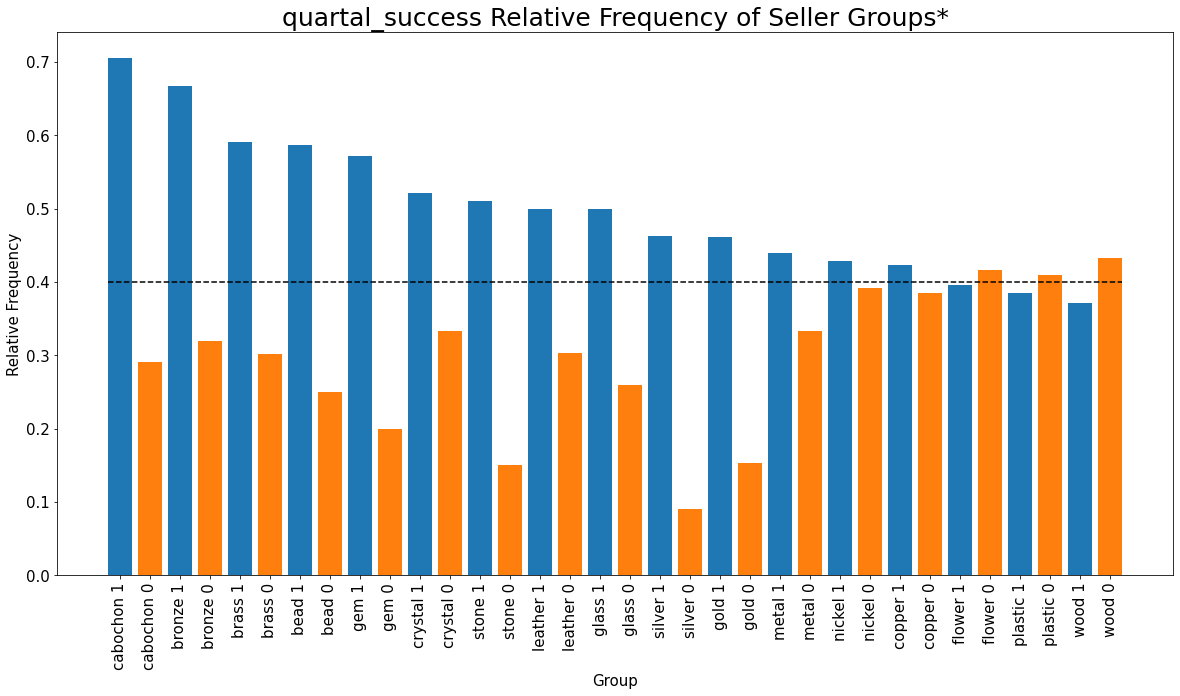

In [ ]:
materials = ['flower', 'gold', 'silver',
       'bronze', 'metal', 'wood', 'gem', 'nickel', 'brass',
       'leather', 'glass', 'stone', 'cabochon', 'crystal', 'bead', 'copper',
       'plastic']

ordered_materials = show_ab_tests(seller_data, materials, 'quartal_success')

In [ ]:
do_ab_tests(seller_data, ordered_materials, 'quartal_success')

CABOCHON
quartal_success   0   1
cabochon               
0                34  14
1                 5  12
chi2 is 7.331750408496731 with a degrees of freedom 1
p-value: 0.006774704655682027
significant

BRONZE
quartal_success   0   1
bronze                 
0                34  16
1                 5  10
chi2 is 4.423611111111111 with a degrees of freedom 1
p-value: 0.03544494876167348
significant

BRASS
quartal_success   0   1
brass                  
0                30  13
1                 9  13
chi2 is 3.919353417899928 with a degrees of freedom 1
p-value: 0.047733235543798734
significant

BEAD
quartal_success   0   1
bead                   
0                27   9
1                12  17
chi2 is 6.2286478288633464 with a degrees of freedom 1
p-value: 0.012569968550738162
significant

GEM
quartal_success   0   1
gem                    
0                24   6
1                15  20
chi2 is 7.802579365079366 with a degrees of freedom 1
p-value: 0.005217170782127536
significant

CRYS

*Seller groups: ['flower', 'gold', 'silver', 'bronze', 'metal', 'wood', 'gem', 'nickel', 'brass', 'leather', 'glass', 'stone', 'cabochon', 'crystal', 'bead', 'copper', 'plastic']


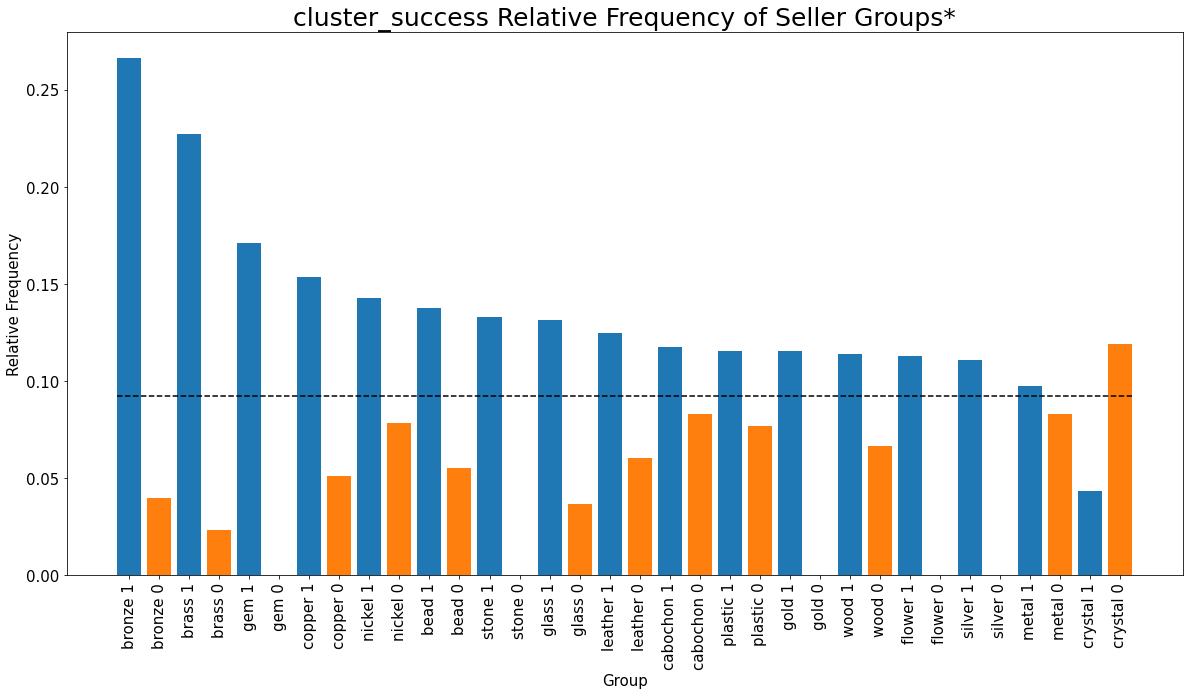

In [ ]:
ordered_materials = show_ab_tests(seller_data, materials, 'cluster_success')

In [ ]:
do_ab_tests(seller_data, ordered_materials, 'cluster_success')

BRONZE
cluster_success   0  1
bronze                
0                48  2
1                11  4
chi2 is 4.628648775894538 with a degrees of freedom 1
p-value: 0.03144231699016435
significant

BRASS
cluster_success   0  1
brass                 
0                42  1
1                17  5
chi2 is 4.999988802092665 with a degrees of freedom 1
p-value: 0.02534748267117684
significant

GEM
cluster_success   0  1
gem                   
0                30  0
1                29  6
chi2 is 3.804563492063492 with a degrees of freedom 1
p-value: 0.051113096931038604
not significant

COPPER
cluster_success   0  1
copper                
0                37  2
1                22  4
chi2 is 0.9257297551789081 with a degrees of freedom 1
p-value: 0.33597500941144665
not significant

NICKEL
cluster_success   0  1
nickel                
0                47  4
1                12  2
chi2 is 0.046868323600626635 with a degrees of freedom 1
p-value: 0.8286050928574267
not significant

BEAD
cluster_

    • Bronze and brass has significantly higher relative frequency of quartal or cluster success.
      In other words bronze and brass product sellers are more likely to be successful in both quartal and
      cluster success measures.
    • Cabochon, bead and gem has significantly higher relative frequency of quartal success.
      In other words cabochon, bead and gem product sellers are more likely to be successful in quartal success measure.

### Colors

*Seller groups: ['white', 'black', 'red', 'green', 'blue', 'yellow', 'brown', 'purple', 'pink', 'orange', 'turquoise']


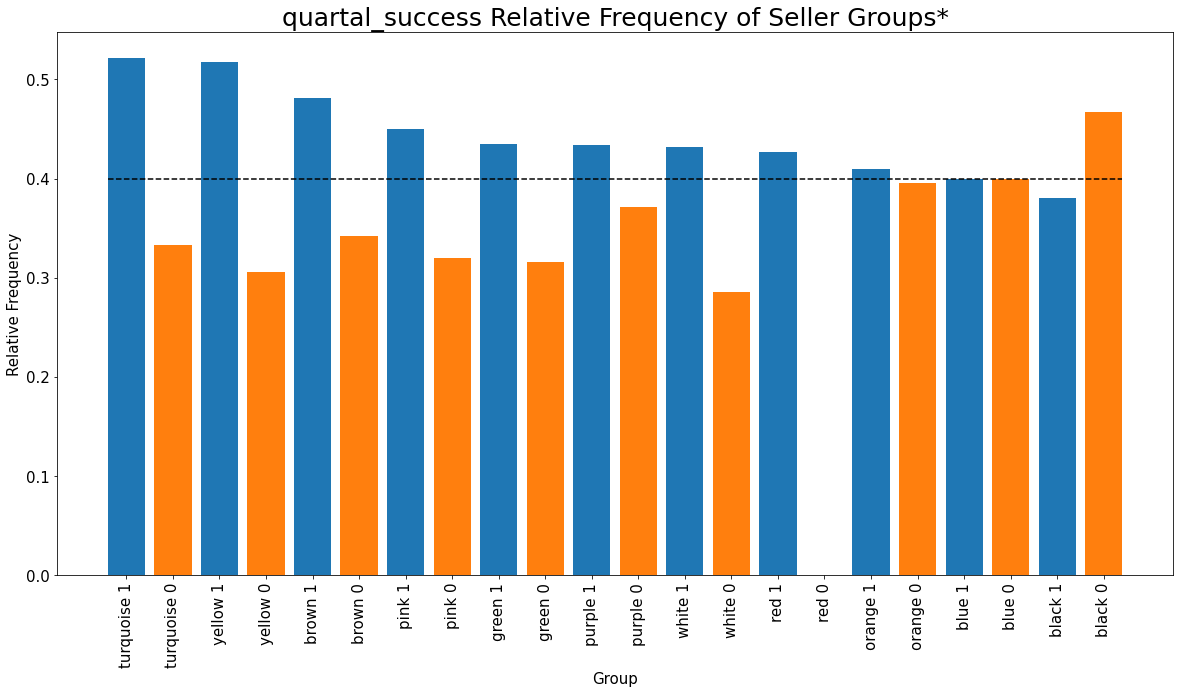

In [ ]:
colors = ['white', 'black', 'red', 'green', 'blue', 'yellow', 'brown', 'purple', 'pink', 
    'orange','turquoise']

ordered_colors = show_ab_tests(seller_data, colors, 'quartal_success')

In [ ]:
do_ab_tests(seller_data, ordered_colors, 'quartal_success')

TURQUOISE
quartal_success   0   1
turquoise              
0                28  14
1                11  12
chi2 is 1.4831349206349216 with a degrees of freedom 1
p-value: 0.22328467831708843
not significant

YELLOW
quartal_success   0   1
yellow                 
0                25  11
1                14  15
chi2 is 2.1817129629629624 with a degrees of freedom 1
p-value: 0.1396589449135763
not significant

BROWN
quartal_success   0   1
brown                  
0                25  13
1                14  13
chi2 is 0.7628736192332677 with a degrees of freedom 1
p-value: 0.38243072434535275
not significant

PINK
quartal_success   0   1
pink                   
0                17   8
1                22  18
chi2 is 0.609375 with a degrees of freedom 1
p-value: 0.4350232307632306
not significant

GREEN
quartal_success   0   1
green                  
0                13   6
1                26  20
chi2 is 0.374952326468345 with a degrees of freedom 1
p-value: 0.5403171236165929
not signific

*Seller groups: ['white', 'black', 'red', 'green', 'blue', 'yellow', 'brown', 'purple', 'pink', 'orange', 'turquoise']


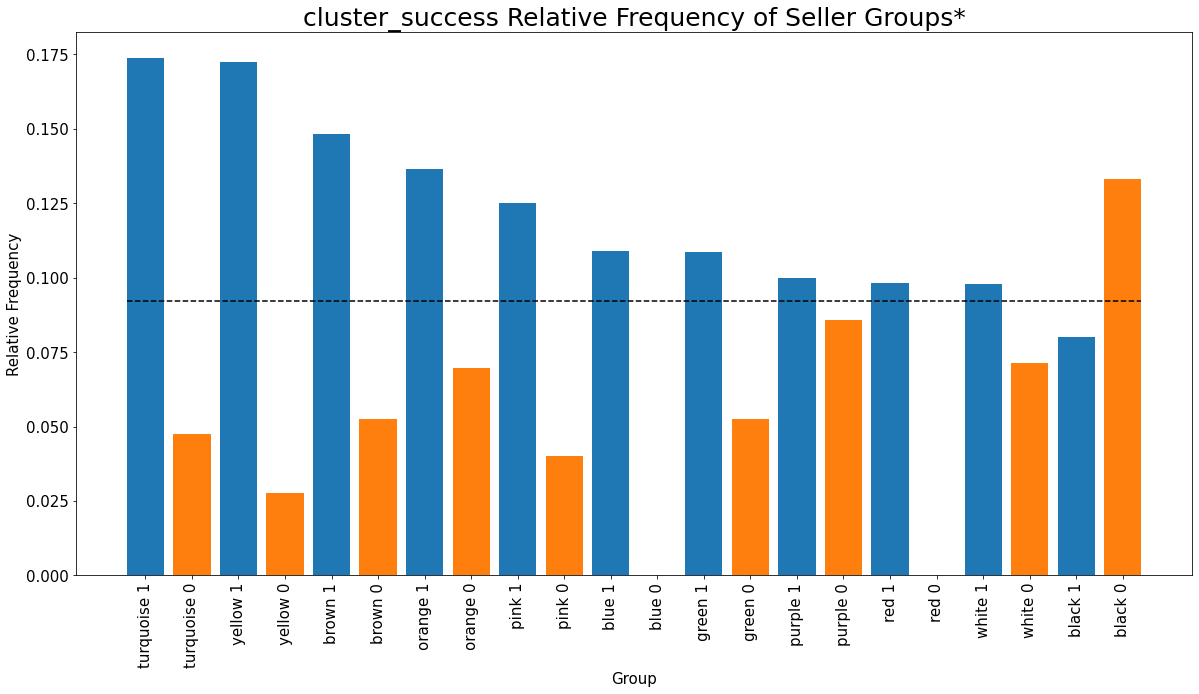

In [ ]:
ordered_colors = show_ab_tests(seller_data, colors, 'cluster_success')

In [ ]:
do_ab_tests(seller_data, ordered_colors, 'cluster_success')

TURQUOISE
cluster_success   0  1
turquoise             
0                40  2
1                19  4
chi2 is 1.5225762068521833 with a degrees of freedom 1
p-value: 0.21723005226046982
not significant

YELLOW
cluster_success   0  1
yellow                
0                35  1
1                24  5
chi2 is 2.4697119131112415 with a degrees of freedom 1
p-value: 0.11605919495976834
not significant

BROWN
cluster_success   0  1
brown                 
0                36  2
1                23  4
chi2 is 0.7677950958689885 with a degrees of freedom 1
p-value: 0.3809000225155197
not significant

ORANGE
cluster_success   0  1
orange                
0                40  3
1                19  3
chi2 is 0.18055879050656357 with a degrees of freedom 1
p-value: 0.6708934639955981
not significant

PINK
cluster_success   0  1
pink                  
0                24  1
1                35  5
chi2 is 0.5060911016949149 with a degrees of freedom 1
p-value: 0.4768359018958108
not significant

BL

Nothing significant.
We couldn't falsify independence of color and relative frequency of quartal or cluster success.

### Themes

*Seller groups: ['vintage', 'hippie', 'minimal']


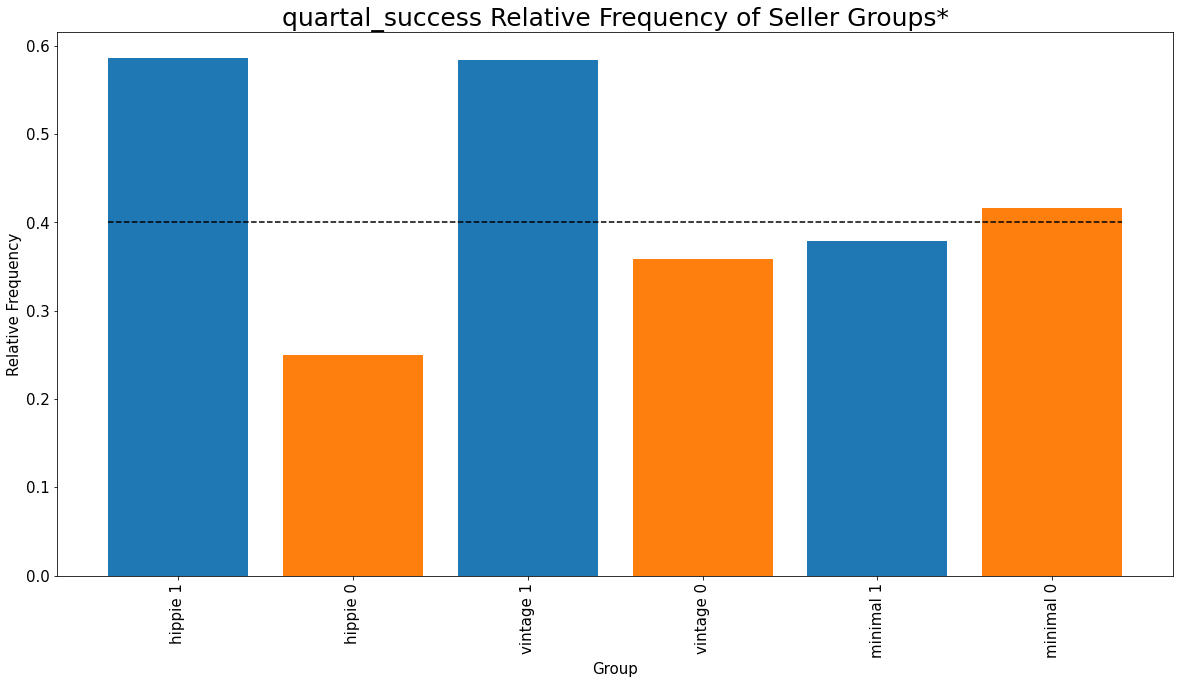

In [ ]:
themes = ['vintage', 'hippie', 'minimal']

ordered_themes = show_ab_tests(seller_data, themes, 'quartal_success')

In [ ]:
do_ab_tests(seller_data, ordered_themes, 'quartal_success')

HIPPIE
quartal_success   0   1
hippie                 
0                27   9
1                12  17
chi2 is 6.2286478288633464 with a degrees of freedom 1
p-value: 0.012569968550738162
significant

VINTAGE
quartal_success   0   1
vintage                
0                34  19
1                 5   7
chi2 is 1.2306734800838575 with a degrees of freedom 1
p-value: 0.26727610221036413
not significant

MINIMAL
quartal_success   0   1
minimal                
0                21  15
1                18  11
chi2 is 0.0025941890166028283 with a degrees of freedom 1
p-value: 0.9593787644966463
not significant



*Seller groups: ['vintage', 'hippie', 'minimal']


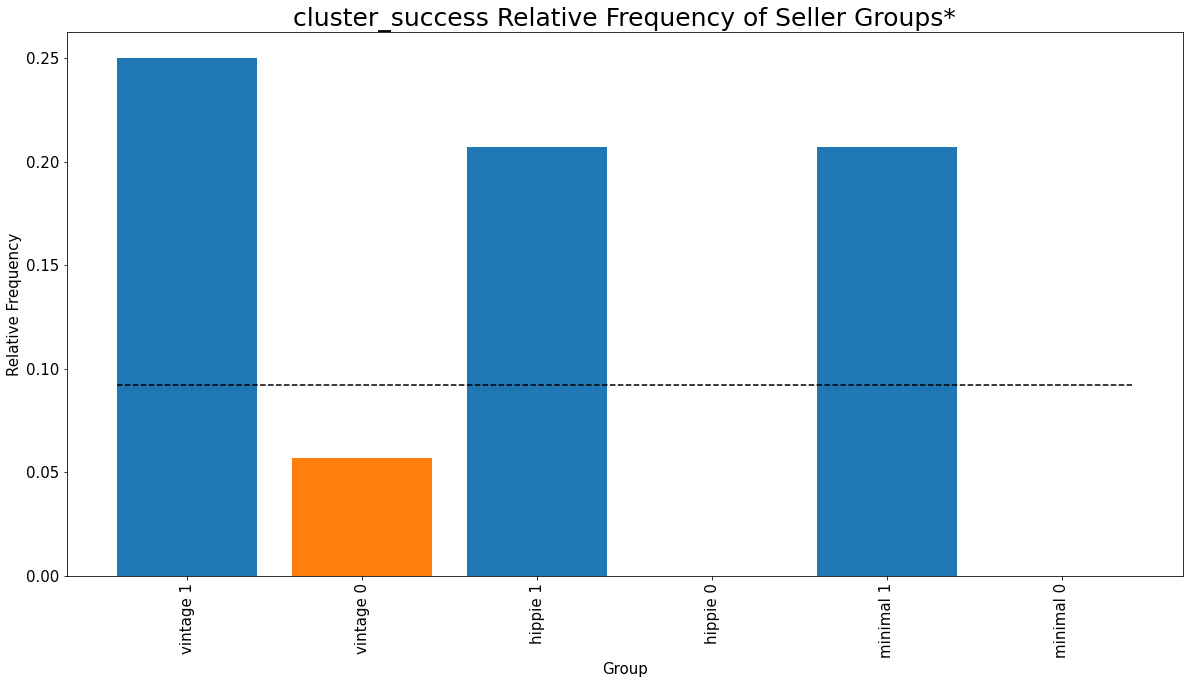

In [ ]:
ordered_themes = show_ab_tests(seller_data, themes, 'cluster_success')

In [ ]:
do_ab_tests(seller_data, ordered_themes, 'cluster_success')

VINTAGE
cluster_success   0  1
vintage               
0                50  3
1                 9  3
chi2 is 2.364558904523327 with a degrees of freedom 1
p-value: 0.12411899181532644
not significant

HIPPIE
cluster_success   0  1
hippie                
0                36  0
1                23  6
chi2 is 5.922181770461286 with a degrees of freedom 1
p-value: 0.014951433065419656
significant

MINIMAL
cluster_success   0  1
minimal               
0                36  0
1                23  6
chi2 is 5.922181770461286 with a degrees of freedom 1
p-value: 0.014951433065419656
significant



    • Hippie has significantly higher relative frequency of quartal or cluster success than the non-hippies.
      In other words hippie product sellers are more likely to be successful in both quartal and
      cluster success measures.
    • Minimal has significantly higher relative frequency of cluster success.
      In other words minimal product sellers are more likely to be successful in cluster success measure.

### Personalization

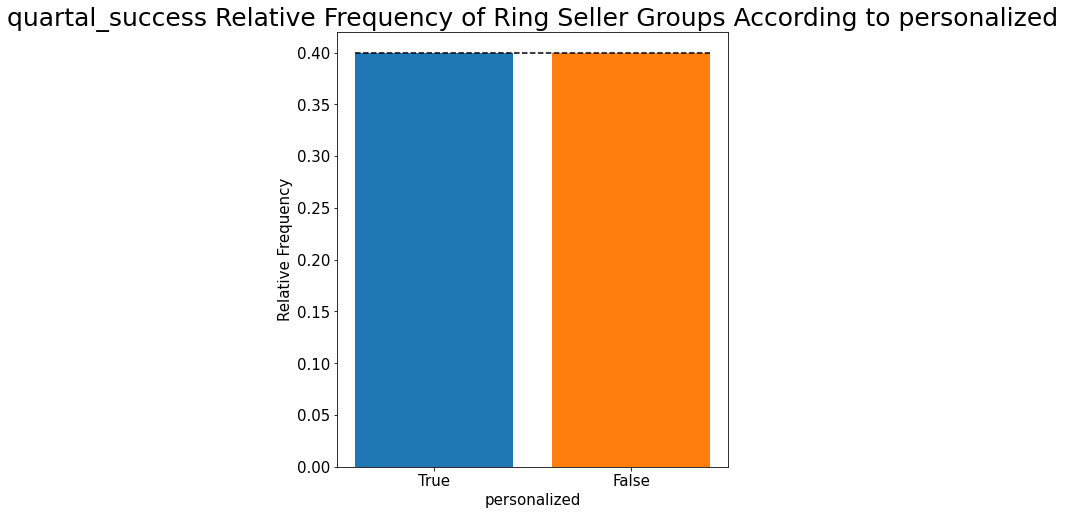

In [ ]:
show_ab_test(seller_data, 'personalized', 'quartal_success')

Frequencies are same. No test needed.

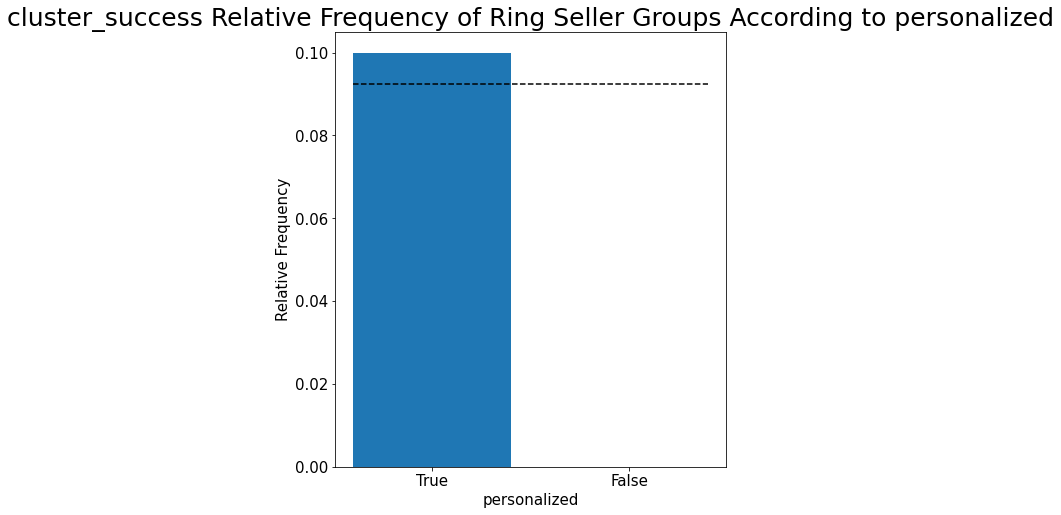

In [ ]:
show_ab_test(seller_data, 'personalized', 'cluster_success')

In [ ]:
do_ab_test(seller_data, 'personalized', 'cluster_success')

PERSONALIZED
cluster_success   0  1
personalized          
0                 5  0
1                54  6
chi2 is 0.0038253295668549845 with a degrees of freedom 1
p-value: 0.9506828837245868
not significant



Nothing significant.

### Transparent

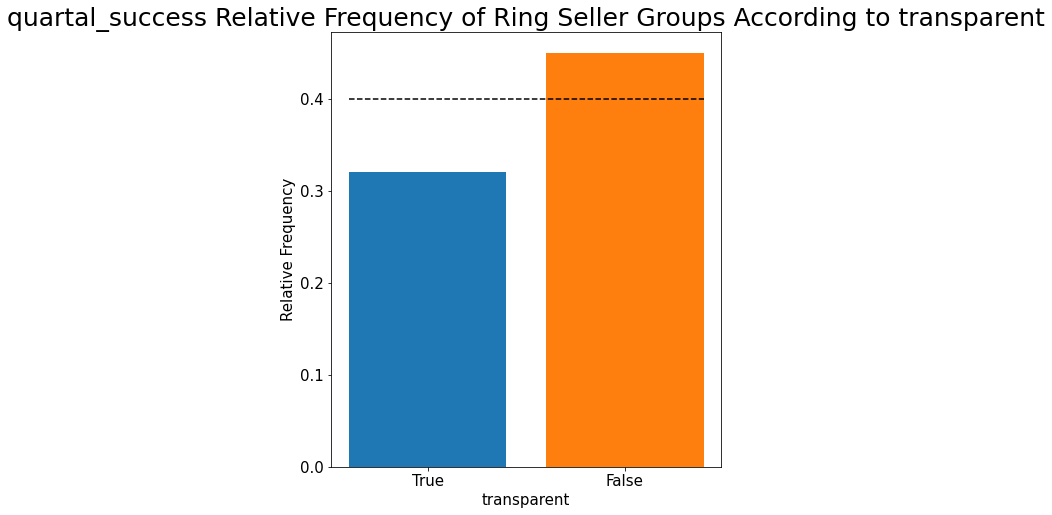

In [ ]:
show_ab_test(seller_data, 'transparent', 'quartal_success')

In [ ]:
do_ab_test(seller_data, 'transparent', 'quartal_success')

TRANSPARENT
quartal_success   0   1
transparent            
0                22  18
1                17   8
chi2 is 0.609375 with a degrees of freedom 1
p-value: 0.4350232307632306
not significant



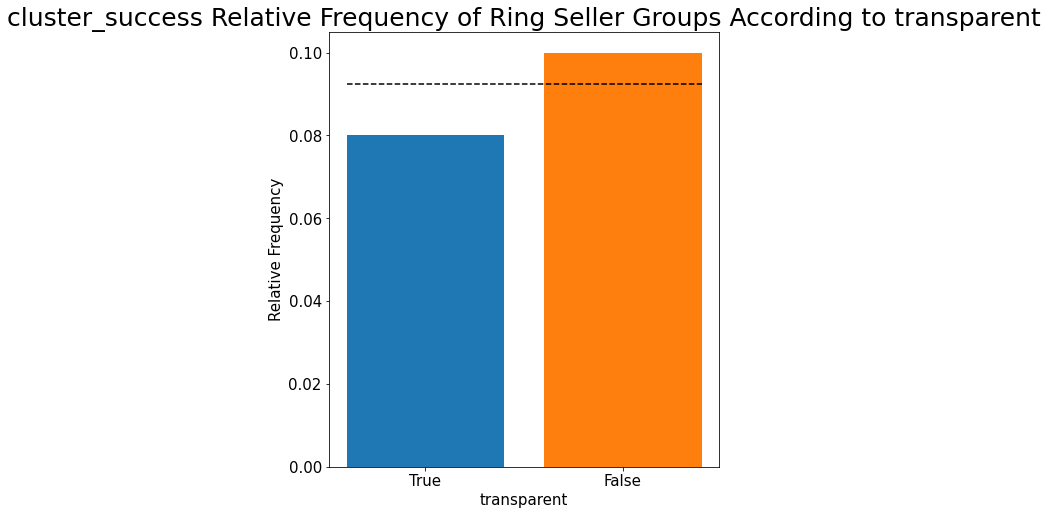

In [ ]:
show_ab_test(seller_data, 'transparent', 'cluster_success')

In [ ]:
do_ab_test(seller_data, 'transparent', 'cluster_success')

TRANSPARENT
cluster_success   0  1
transparent           
0                36  4
1                23  2
chi2 is 0.028689971751412517 with a degrees of freedom 1
p-value: 0.8654968545583605
not significant



Nothing significant.

### Matt

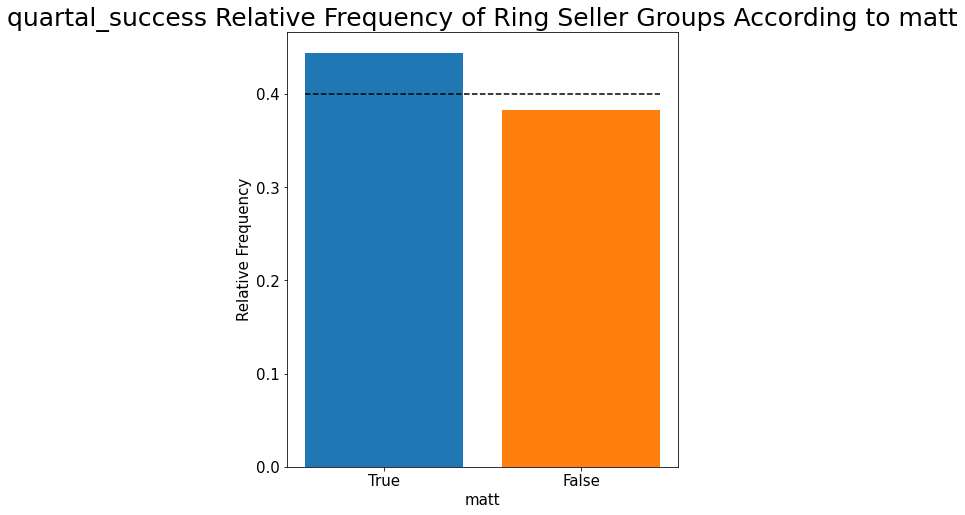

In [ ]:
show_ab_test(seller_data, 'matt', 'quartal_success')

In [ ]:
do_ab_test(seller_data, 'matt', 'quartal_success')

MATT
quartal_success   0   1
matt                   
0                29  18
1                10   8
chi2 is 0.028812056737588715 with a degrees of freedom 1
p-value: 0.8652137135428795
not significant



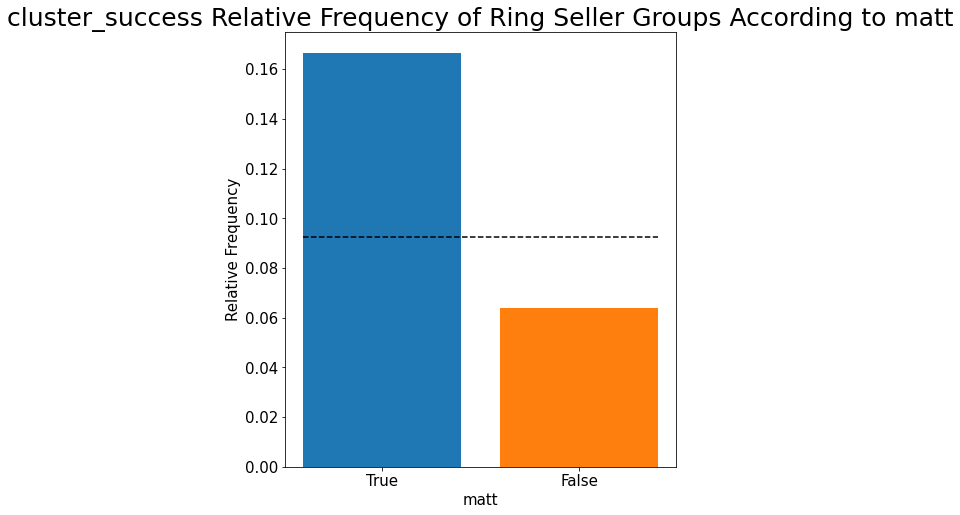

In [ ]:
show_ab_test(seller_data, 'matt', 'cluster_success')

In [ ]:
do_ab_test(seller_data, 'matt', 'cluster_success')

MATT
cluster_success   0  1
matt                  
0                44  3
1                15  3
chi2 is 0.6446629870043137 with a degrees of freedom 1
p-value: 0.4220272888306912
not significant



Nothing significant.

### Waterproof

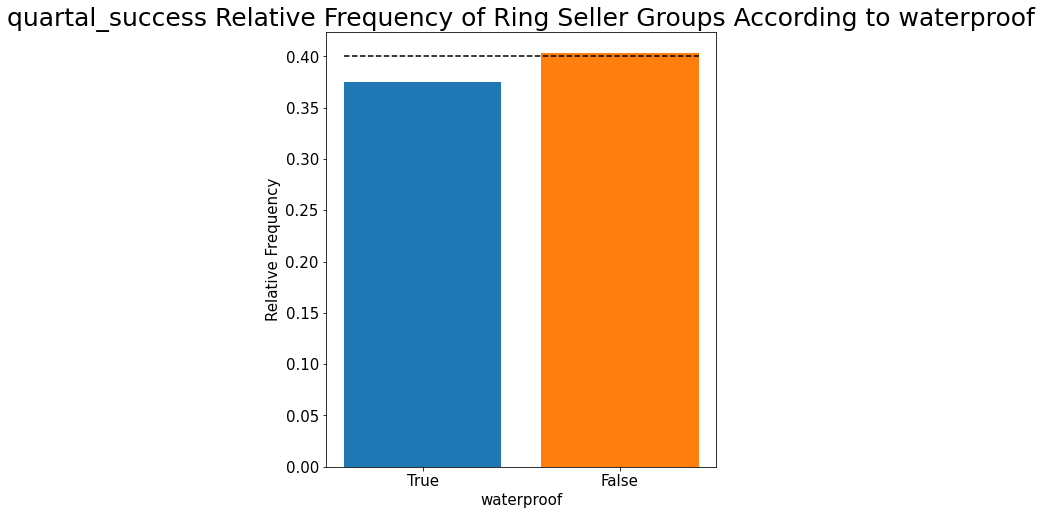

In [ ]:
show_ab_test(seller_data, 'waterproof', 'quartal_success')

In [ ]:
do_ab_test(seller_data, 'waterproof', 'quartal_success')

WATERPROOF
quartal_success   0   1
waterproof             
0                34  23
1                 5   3
chi2 is 0.05345394736842096 with a degrees of freedom 1
p-value: 0.817158577615827
not significant



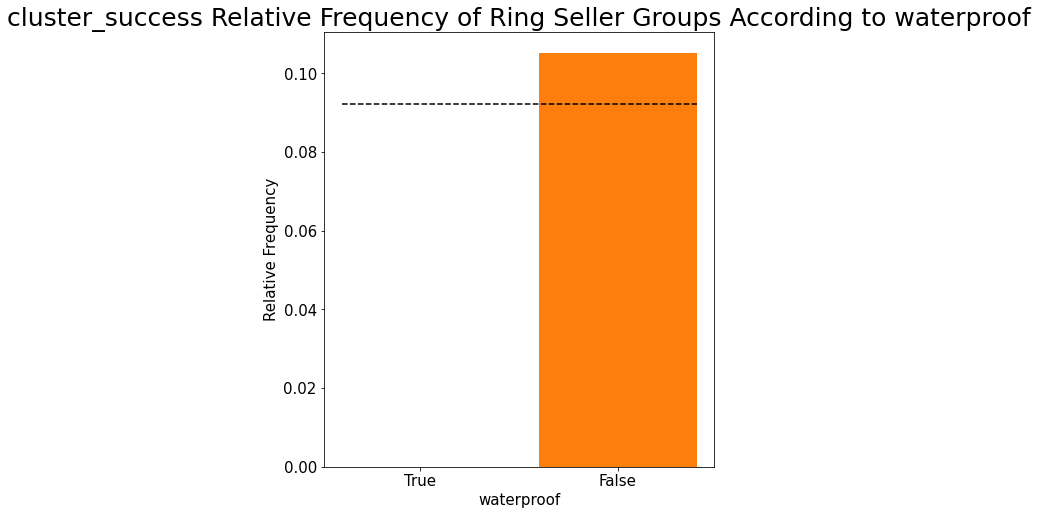

In [ ]:
show_ab_test(seller_data, 'waterproof', 'cluster_success')

In [ ]:
do_ab_test(seller_data, 'waterproof', 'cluster_success')

WATERPROOF
cluster_success   0  1
waterproof            
0                51  6
1                 8  0
chi2 is 0.09674057141441172 with a degrees of freedom 1
p-value: 0.7557767025166268
not significant



Nothing significant.

### Polished

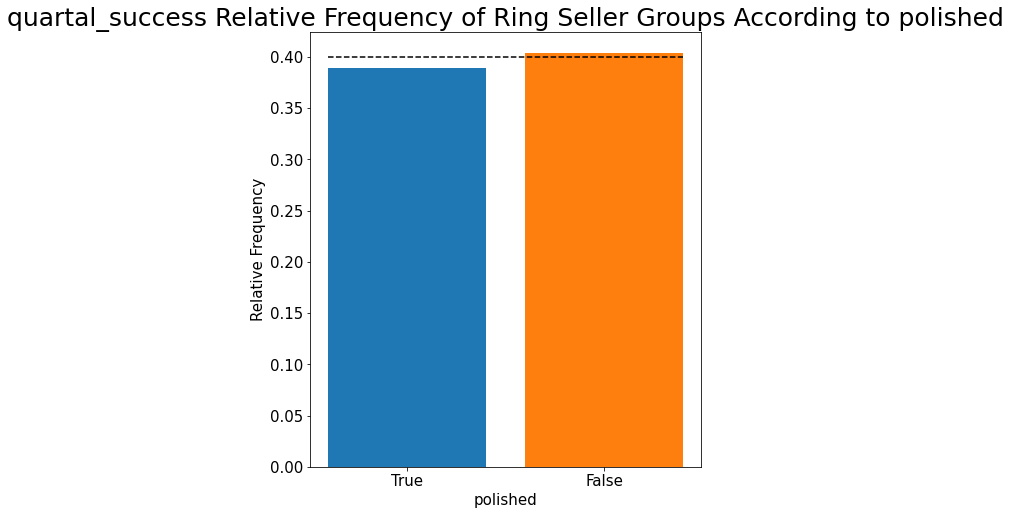

In [ ]:
show_ab_test(seller_data, 'polished', 'quartal_success')

In [ ]:
do_ab_test(seller_data, 'polished', 'quartal_success')

POLISHED
quartal_success   0   1
polished               
0                28  19
1                11   7
chi2 is 0.028812056737588715 with a degrees of freedom 1
p-value: 0.8652137135428795
not significant



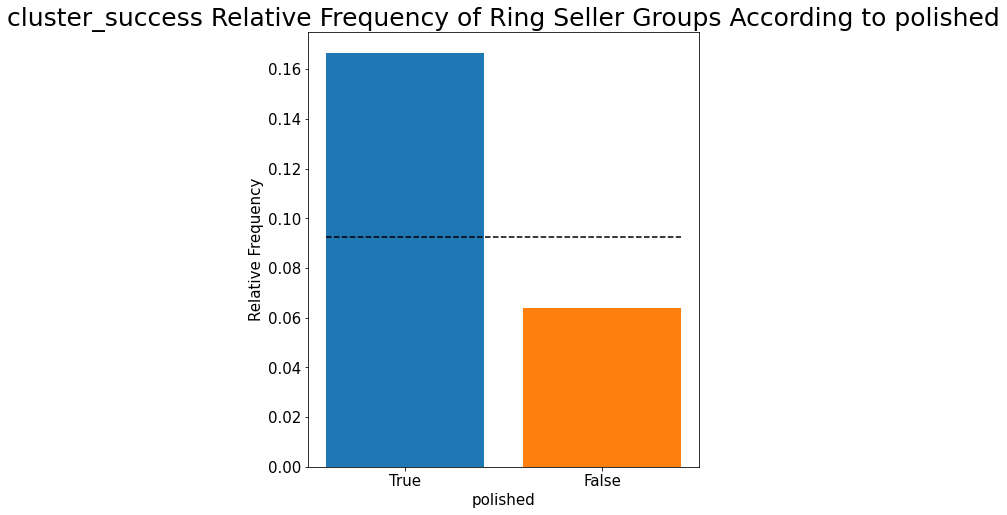

In [ ]:
show_ab_test(seller_data, 'polished', 'cluster_success')

In [ ]:
do_ab_test(seller_data, 'polished', 'cluster_success')

POLISHED
cluster_success   0  1
polished              
0                44  3
1                15  3
chi2 is 0.6446629870043137 with a degrees of freedom 1
p-value: 0.4220272888306912
not significant



Nothing significant.

### Plated

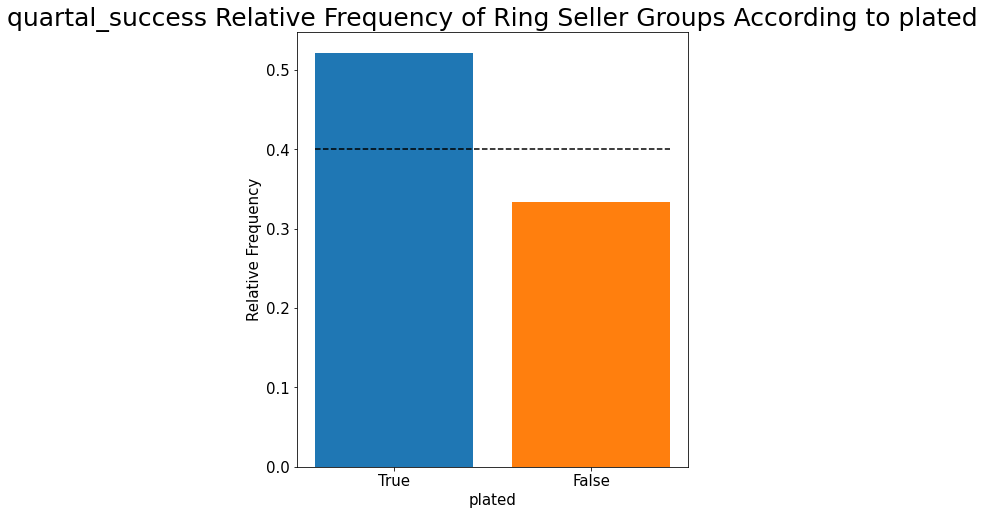

In [ ]:
show_ab_test(seller_data, 'plated', 'quartal_success')

In [ ]:
do_ab_test(seller_data, 'plated', 'quartal_success')

PLATED
quartal_success   0   1
plated                 
0                28  14
1                11  12
chi2 is 1.4831349206349216 with a degrees of freedom 1
p-value: 0.22328467831708843
not significant



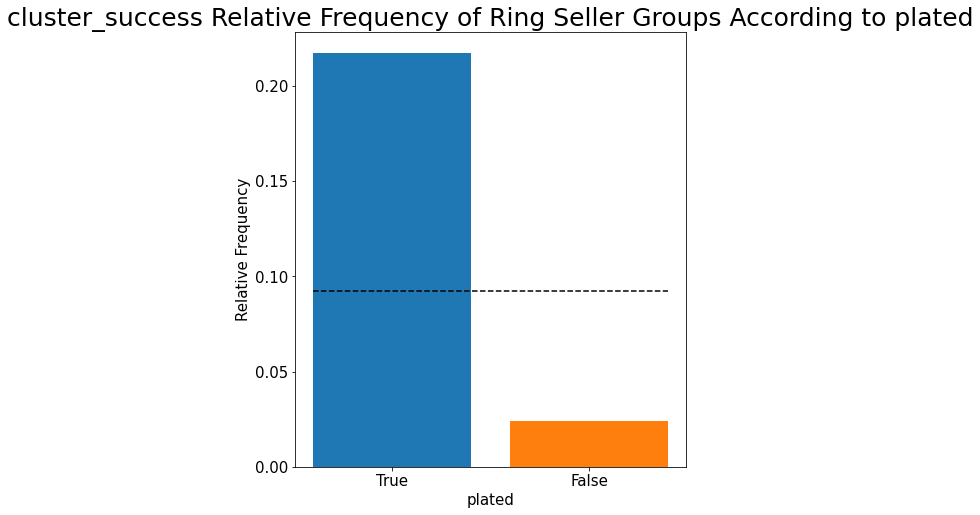

In [ ]:
show_ab_test(seller_data, 'plated', 'cluster_success')

In [ ]:
do_ab_test(seller_data, 'plated', 'cluster_success')

PLATED
cluster_success   0  1
plated                
0                41  1
1                18  5
chi2 is 4.537221023265607 with a degrees of freedom 1
p-value: 0.03316539252598536
significant



    • Plated product sellers have a significantly higher relative frequency of cluster succes than only 
      non-plated product sellers.
      In other words plated product sellers are more likely to be successful cluster success measure.

### Adjustable

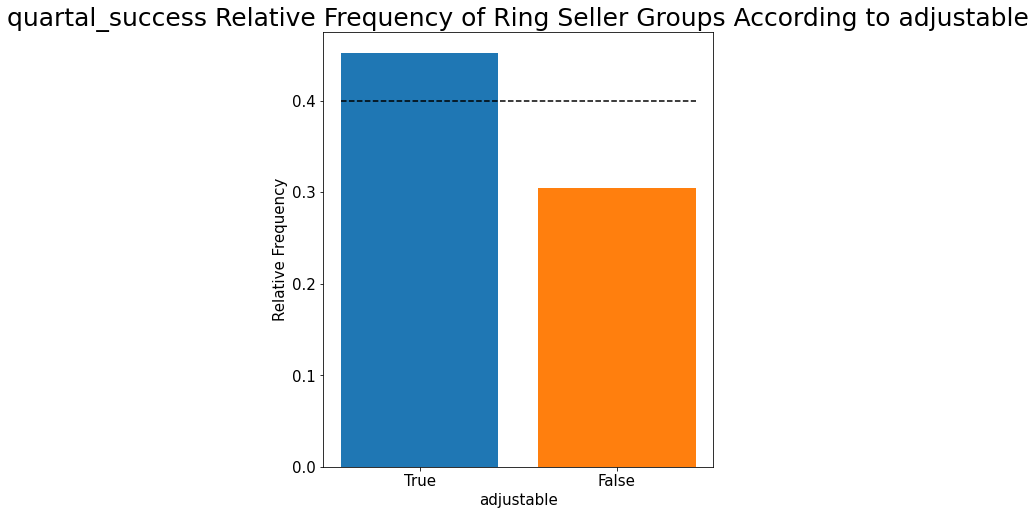

In [ ]:
show_ab_test(seller_data, 'adjustable', 'quartal_success')

In [ ]:
do_ab_test(seller_data, 'adjustable', 'quartal_success')

ADJUSTABLE
quartal_success   0   1
adjustable             
0                16   7
1                23  19
chi2 is 0.8102570738440297 with a degrees of freedom 1
p-value: 0.36804425765356674
not significant



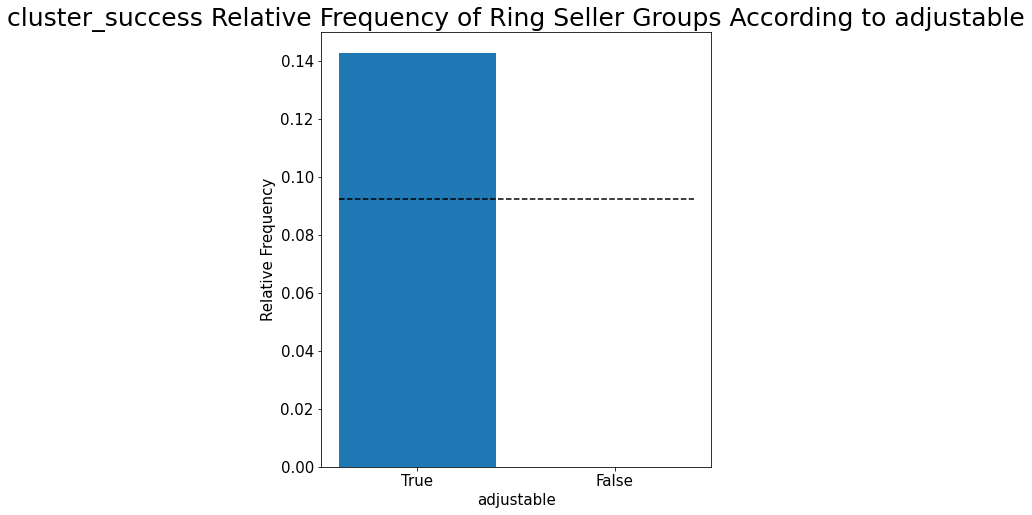

In [ ]:
show_ab_test(seller_data, 'adjustable', 'cluster_success')

In [ ]:
do_ab_test(seller_data, 'adjustable', 'cluster_success')

ADJUSTABLE
cluster_success   0  1
adjustable            
0                23  0
1                36  6
chi2 is 2.115621088769578 with a degrees of freedom 1
p-value: 0.14580289183016848
not significant



Nothing significant.

## Summary and Evaluation of Findings

    Success Groups of Sellers:
    
    Based on our methods we divided sellers in groups according to their revenues: 
    0 (Not so successful) and 1 (successful).
    Successful sellers based on quartals (which are in the top quartal) have a mean revenue of approximately 
    21210€.
    Successful sellers based on clusters (which are in the top 2 clusters) have a mean revenue of approximately
    73777€.
    
    
    Product Types:
    
    Sellers of ring, necklace and earring products are significantly more likely to be successful based on 
    quartals.
    Ring sellers are also significantly more likely to be successful based on clusters.
    Based on both methods ring sellers have the highest relative frequency of being successful with
    a rel. freq. of 40% based on quartals and 9,2308% based on clusters.
    Options:
        1. Rings can be good, if you are aiming succes based on any method. 
        2. Necklace and earrings can also be a good option for the product variety, if you are aiming quartal 
           success.
    
    
    Features of Ring Products:
    
    Materials:
    Bronze and brass product sellers are more likely to be successful in both quartal and cluster 
    success measures.
    Cabochon, bead and gem product sellers are more likely to be successful in quartal success measure.
    Only sellers of products with cabochon are more likely to be successful based on quartals than bronze and 
    brass product sellers.
    Options:
        1. Bronze and brass can be good, if you are aiming quartal and cluster success.
        2. Cabochon can be good, if you are aiming only quartal success.
        3. Bead and gem can be good for product variety, if you are aiming quartal success.
    
    Themes:
    Sellers of products with a hippie theme are more likely to be successful in both quartal and
    cluster success measures.
    Minimal product sellers are more likely to be successful in cluster success measure.
    Options:
        1. Hippie themes can be good, if you are aiming quartal and cluster success.
        2. In addition to that minimal themes can be good for the product variety, if you are aiming 
           cluster success.
        
    Plated Products:
    Sellers of plated products are more likely to be successful in cluster success measure.
    Option: Selling plated products can be an option, if you are aiming success in cluster base.


    *Note: In this text when I use 'Sellers of x products are more likely to be successful', 
           I mean 'Sellers of x products are more likely to be successful than sellers of non-x products'.